<a id='section1'></a>
# 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so

from scipy import stats
from scipy.stats.contingency import association

from sklearn.preprocessing import LabelEncoder

from loguru import logger
from omegaconf import OmegaConf

pd.set_option('display.max_columns', None)
pd.options.plotting.backend = 'matplotlib'

In [2]:
hotel = pd.read_csv('../../data/raw/hotel_reservations.csv')
hotel

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,INN00001,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,2017,10,2,Offline,0,0,0,65.00,0,Not_Canceled
1,INN00002,2,0,2,3,Not Selected,0,Room_Type 1,5,2018,11,6,Online,0,0,0,106.68,1,Not_Canceled
2,INN00003,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,2018,2,28,Online,0,0,0,60.00,0,Canceled
3,INN00004,2,0,0,2,Meal Plan 1,0,Room_Type 1,211,2018,5,20,Online,0,0,0,100.00,0,Canceled
4,INN00005,2,0,1,1,Not Selected,0,Room_Type 1,48,2018,4,11,Online,0,0,0,94.50,0,Canceled
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36270,INN36271,3,0,2,6,Meal Plan 1,0,Room_Type 4,85,2018,8,3,Online,0,0,0,167.80,1,Not_Canceled
36271,INN36272,2,0,1,3,Meal Plan 1,0,Room_Type 1,228,2018,10,17,Online,0,0,0,90.95,2,Canceled
36272,INN36273,2,0,2,6,Meal Plan 1,0,Room_Type 1,148,2018,7,1,Online,0,0,0,98.39,2,Not_Canceled
36273,INN36274,2,0,0,3,Not Selected,0,Room_Type 1,63,2018,4,21,Online,0,0,0,94.50,0,Canceled


In [3]:
hotel.columns.tolist()

['Booking_ID',
 'no_of_adults',
 'no_of_children',
 'no_of_weekend_nights',
 'no_of_week_nights',
 'type_of_meal_plan',
 'required_car_parking_space',
 'room_type_reserved',
 'lead_time',
 'arrival_year',
 'arrival_month',
 'arrival_date',
 'market_segment_type',
 'repeated_guest',
 'no_of_previous_cancellations',
 'no_of_previous_bookings_not_canceled',
 'avg_price_per_room',
 'no_of_special_requests',
 'booking_status']

<a id='section2'></a>
# 2. Dataset Info

   #### Source:
   https://www.kaggle.com/datasets/ahsan81/hotel-reservations-classification-dataset

   #### DBA4714 Deep Learning and Generative AI in Business
   Revenue Management in Hotel Reservations

   #### Problem Statement
   The online hotel reservation channels have dramatically changed booking possibilities and customers’ behavior. A significant number of hotel reservations are called-off due to cancellations or no-shows. The typical reasons for cancellations include change of plans, scheduling conflicts, etc. This is often made easier by the option to do so free of charge or preferably at a low cost which is beneficial to hotel guests but it is a less desirable and possibly revenue-diminishing factor for hotels to deal with.

   #### Train data:
| No. | Features | Description |
| :-------- | :-------- | :-------- |
| 1. | Booking_ID | Unique identifier of each booking |
| 2. | no_of_adults | Number of adults |
| 3. | no_of_children | Number of Children |
| 4. | no_of_weekend_nights | Number of weekend nights (Saturday or Sunday) the guest stayed or booked to stay at the hotel |
| 5. | no_of_week_nights | Number of week nights (Monday to Friday) the guest stayed or booked to stay at the hotel |
| 6. | type_of_meal_plan | Type of meal plan booked by the customer |
| 7. | required_car_parking_space | Does the customer require a car parking space? (0 - No, 1- Yes) |
| 8. | room_type_reserved | Type of room reserved by the customer. The values are ciphered (encoded) by INN Hotels. |
| 9. | lead_time | Number of days between the date of booking and the arrival date |
| 10. | arrival_year | Year of arrival date |
| 11. | arrival_month | Month of arrival date |
| 12. | arrival_date | Date of the month |
| 13. | market_segment_type | Market segment designation |
| 14. | repeated_guest | Is the customer a repeated guest? (0 - No, 1- Yes) |
| 15. | no_of_previous_cancellations | Number of previous bookings that were canceled by the customer prior to the current bookinge |
| 16. | no_of_previous_bookings_not_canceled | Number of previous bookings not canceled by the customer prior to the current booking |
| 17. | avg_price_per_room | Average price per day of the reservation; prices of the rooms are dynamic. (in euros) |
| 18. | no_of_special_requests | Total number of special requests made by the customer (e.g. high floor, view from the room, etc) |
| 19. | booking_status | Flag indicating if the booking was canceled or not |

# Temp Helper

In [4]:
def cat_value_count(df: pd.DataFrame, 
                    col: str,  
                    reindex: list = None) -> pd.DataFrame:
    
    df = df.assign(booking_status=lambda df_: df_["booking_status"].map({"Not_Canceled": 0, "Canceled": 1}))
    return (pd
            .DataFrame((df[col].value_counts(normalize=i) for i in [False, True]), index=['abs_count', 'norm_count'])
            .T
            .reindex(reindex)
            .assign(cumsum=lambda df_: df_.norm_count.cumsum(),
                    mean_target=df.groupby(col)["booking_status"].mean())
        #     .sort_index(ascending=True)
            .pipe(lambda df_: print(f'This categorical predictor has {len(df_)} unique values\n\n', df_))
           )

In [5]:
color_palette = ["#CF2011", "#E42313", "#EB5A4E", "#F29189", "#FFFFFF", "#B8B7B7", "#706F6F", "#1D1D1B"]
fp = (matplotlib
      .font_manager
      .FontProperties(fname='/Fonts/roboto/Roboto-Condensed.ttf')
     )
sns.set_palette(color_palette)
sns.set_style("whitegrid", 
              {"grid.color": "#ffffff", 
               "axes.facecolor": "w", 
               "figure.facecolor":"white"})

In [6]:
def plot_categorical(df: pd.DataFrame, 
                     col: str, 
                     new_index: list = None) -> so:

    df_to_plot = df[col].value_counts(normalize=True).to_frame().reset_index()

    if new_index is not None:
        df_to_plot = df_to_plot.set_index('index').reindex(new_index).reset_index()

    return (so
            .Plot(df_to_plot, x=col, y='proportion')
            .add(so.Bar(color=color_palette[2], alpha=1.0, edgewidth=0))
            .theme({"axes.facecolor": "w", "grid.color": "#ffffff"})
            .label(x='',
                   y=col,
                   color=str.capitalize,
                   title=f'Normalised Count of {col}')
            .show()
           )

In [7]:
def outlier_thresholds(df: pd.DataFrame, 
                       col: str, 
                       q1: float = 0.05, 
                       q3: float = 0.95):
    """
    1.5 as multiplier is a rule of thumb. Generally, the higher the multiplier,
    the outlier threshold is set farther from the third quartile, allowing fewer data points to be classified as outliers
    """

    return (df[col].quantile(q1) - 1.5 * (df[col].quantile(q3) - df[col].quantile(q1)),
            df[col].quantile(q3) + 1.5 * (df[col].quantile(q3) - df[col].quantile(q1)))

def loc_potential_outliers(df: pd.DataFrame,
                           col: str):
    """
    Locate potential outliers and print the result in DataFrame
    """
    
    low, high = outlier_thresholds(df, col)
    res = df.loc[(df[col] < low) | (df[col] > high)]
    print(f'Detected total of {len(res)} potential outliers based on 1.5xIQR with min of {res[col].min()} and max of {res[col].max()}')
    return res

def any_potential_outlier(df: pd.DataFrame, 
                          col: str) -> int:
    """
    Quick check on outlier counts across columns
    """
    
    low, high = outlier_thresholds(df, col)
    outlier_condition = (df[col] > high) | (df[col] < low)
    
    if outlier_condition.any():
        return df.loc[outlier_condition].shape[0]
    else:
        return 0

In [8]:
def plot_continuous(df: pd.DataFrame, 
                    col: str, 
                    title: str, 
                    symb: str):
    """
    Plot a Boxplot and Histogram to inspect continuous values distribution.
    """
    
    with sns.plotting_context(rc={"font":"Roboto", "palette":color_palette, "grid.linewidth":1.0, "font.size":12.0}):
        fig, ax = plt.subplots(2, 1, sharex=True, figsize=(8, 5), gridspec_kw={"height_ratios": (.2, .8)})

        ax[0].set_title(title,fontsize=18)
        (df
         [[col]]
         .boxplot(ax=ax[0], vert=False))

        ax[0].set(yticks=[])
        
        # Remove the spines for the first axis
        for spine in ['top', 'bottom', 'left', 'right']:
            ax[0].spines[spine].set_visible(False)

        (so
         .Plot(df,
               x=col)
         .add(so.Bars(color=color_palette[0]), so.Hist(bins=50))
         .label(x=col,
                y='Frequency',
                color=str.capitalize,)
         .on(ax[1])
         .plot()
        )
        
        # Remove the spines for the second axis
        for spine in ['top', 'bottom', 'left', 'right']:
            ax[1].spines[spine].set_visible(False)

        plt.axvline(df[col].mean(), color=color_palette[2], linestyle='--', linewidth=2.2, label='mean=' + str(np.round(df[col].astype('float64').mean(),1)) + symb)
        plt.axvline(df[col].median(), color=color_palette[3], linestyle='--', linewidth=2.2, label='median='+ str(np.round(df[col].median(),1)) + symb)
        plt.axvline(df[col].mode()[0], color=color_palette[4], linestyle='--', linewidth=2.2, label='mode='+ str(np.round(df[col].mode()[0],1)) + symb)
        plt.axvline(df[col].min(), color=color_palette[5], linestyle='--', linewidth=2.2, label='min='+ str(np.round(df[col].min(),1)) + symb)
        plt.axvline(df[col].max(), color=color_palette[6], linestyle='--', linewidth=2.2, label='max='+ str(np.round(df[col].max(),1)) + symb)
        plt.legend(bbox_to_anchor=(1, 1.03), ncol=1, fontsize=10, fancybox=True, shadow=True, frameon=True)
        
        plt.tight_layout()
        plt.show()
        
        plt.close('all')

In [9]:
def plot_qq(df: pd.DataFrame,
            column: str):
    """
    Quantile plot to observe normality
    """
    
    plt.figure()
    stats.probplot(df[column], dist="norm", plot=plt)
    plt.title(f"QQ Plot of {column}")
    plt.gca().get_lines()[0].set_markerfacecolor('#1E1A0F')
    plt.gca().get_lines()[0].set_markeredgecolor('#1E1A0F')
    plt.gca().get_lines()[1].set_color('#575735')
    plt.show()

In [10]:
def test_normality(df: pd.DataFrame, 
                   column: str, 
                   sample_size:int=5000, 
                   random_state:int=1):
    """
    Test the normality of a column in a dataframe using Shapiro-Wilk and D'Agostino and Pearson's tests.
    """

    sample_data = df[column].sample(n=sample_size, random_state=random_state)

    # Shapiro-Wilk Test
    shapiro_test_stat, shapiro_p_value = stats.shapiro(sample_data)
    print(f'Shapiro-Wilk Test (on sample data):\n Test Statistic: {shapiro_test_stat}\n p-value: {shapiro_p_value}')

    # D'Agostino and Pearson's Test
    dagostino_test_stat, dagostino_p_value = stats.normaltest(df[column])
    print(f"\nD'Agostino and Pearson's Test:\n Test Statistic: {dagostino_test_stat}\n p-value: {dagostino_p_value}")

    if shapiro_p_value > 0.05 and dagostino_p_value > 0.05:
        print("\nBoth tests failed to reject the null hypothesis, suggesting the data is normally distributed.")
    else:
        print("\nAt least one of the tests rejected the null hypothesis, suggesting the data is not normally distributed.")

In [11]:
def plot_features_label(df: pd.DataFrame,
                        col: str,
                        new_index: list = None) -> so:
    
    df_to_plot = (df
                   .groupby([col])
                   ['booking_status']
                   .value_counts(normalize=False)
                   .unstack(level=1)
                 )
    
    if new_index is not None:
        df_to_plot = df_to_plot.reindex(new_index)
    
    return (so
            .Plot((df_to_plot
                   .reset_index()
                #    .rename(columns={0: '0', 1: '1'})
                   .melt(id_vars=col, var_name='decision', value_name='proportion')
                  ),
                  x='proportion',
                  y=col,
                  color='decision'
                 )
            .add(so.Bar(edgewidth=0),
                 so.Dodge())
            .theme({"axes.facecolor": "w", "grid.color": "#ffffff"})
            .label(x='',
                   y=col,
                   color=str.capitalize,
                   title=f'{col} v. Cancelled Booking')
            .theme({"axes.prop_cycle": matplotlib.cycler(color=[color_palette[0], color_palette[3]])})
            .plot()
           )

def plot_label_features(df: pd.DataFrame,
                        col: str) -> so:
    
    df_to_plot = (df
                   .assign(booking_status=np.where(df['booking_status'] == "Not_Canceled", 0, 1))
                   .groupby([col])
                   ['booking_status']
                   .value_counts(normalize=True)
                   .unstack(level=0)
                 )
        
    return (so
            .Plot((df_to_plot
                   .reset_index()
                   .melt(id_vars='booking_status', var_name=col, value_name='proportion')
                  ),
                  x='proportion',
                  y='booking_status',
                  color=col
                 )
            .add(so.Bar(edgewidth=0),
                 so.Dodge(),
                 orient='y')
            .label(x='',
                   y='booking_status',
                   color=str.capitalize,
                   title=f'{col} v. Cancelled Booking')
            .scale(y=so.Continuous().tick(at=[0, 1]))
            .theme({"axes.prop_cycle": matplotlib.cycler(color=[color_palette[0], color_palette[3], color_palette[2], color_palette[5]]), "axes.facecolor": "w", "grid.color": "#ffffff"})
            .plot()
           )

In [12]:
cmap_name = 'custom_palette'
cm = (plt
      .cm
      .colors
      .LinearSegmentedColormap
      .from_list(cmap_name, 
                 color_palette, 
                 N=len(color_palette)
                )
     )

<a id='section3'></a>
# 3. Exploratory Data Analysis

In [13]:
(hotel
 .sample(5)
)

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
18278,INN18279,2,0,1,0,Meal Plan 1,0,Room_Type 1,20,2018,6,12,Online,0,0,0,94.35,0,Not_Canceled
27270,INN27271,2,0,2,2,Not Selected,0,Room_Type 1,164,2018,9,4,Online,0,0,0,116.10,0,Canceled
6592,INN06593,2,0,2,0,Meal Plan 1,0,Room_Type 1,5,2017,9,20,Corporate,1,1,0,100.00,0,Not_Canceled
35553,INN35554,1,0,0,3,Meal Plan 1,0,Room_Type 1,13,2018,6,14,Corporate,1,0,7,65.00,1,Not_Canceled
23552,INN23553,1,0,2,2,Not Selected,0,Room_Type 1,62,2018,11,6,Online,0,0,0,140.63,1,Not_Canceled


In [14]:
(hotel
 .shape
)

(36275, 19)

In [15]:
(hotel
 .info()
)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36275 entries, 0 to 36274
Data columns (total 19 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Booking_ID                            36275 non-null  object 
 1   no_of_adults                          36275 non-null  int64  
 2   no_of_children                        36275 non-null  int64  
 3   no_of_weekend_nights                  36275 non-null  int64  
 4   no_of_week_nights                     36275 non-null  int64  
 5   type_of_meal_plan                     36275 non-null  object 
 6   required_car_parking_space            36275 non-null  int64  
 7   room_type_reserved                    36275 non-null  object 
 8   lead_time                             36275 non-null  int64  
 9   arrival_year                          36275 non-null  int64  
 10  arrival_month                         36275 non-null  int64  
 11  arrival_date   

In [16]:
(hotel
 .describe()
)

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,required_car_parking_space,lead_time,arrival_year,arrival_month,arrival_date,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests
count,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000
mean,1.844962,0.105279,0.810724,2.204300,0.030986,85.232557,2017.820427,7.423653,15.596995,0.025637,0.023349,0.153411,103.423539,0.619655
std,0.518715,0.402648,0.870644,1.410905,0.173281,85.930817,0.383836,3.069894,8.740447,0.158053,0.368331,1.754171,35.089424,0.786236
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2017.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,0.000000,17.000000,2018.000000,5.000000,8.000000,0.000000,0.000000,0.000000,80.300000,0.000000
50%,2.000000,0.000000,1.000000,2.000000,0.000000,57.000000,2018.000000,8.000000,16.000000,0.000000,0.000000,0.000000,99.450000,0.000000
75%,2.000000,0.000000,2.000000,3.000000,0.000000,126.000000,2018.000000,10.000000,23.000000,0.000000,0.000000,0.000000,120.000000,1.000000
max,4.000000,10.000000,7.000000,17.000000,1.000000,443.000000,2018.000000,12.000000,31.000000,1.000000,13.000000,58.000000,540.000000,5.000000


In [17]:
(pd
 .value_counts(hotel.dtypes)
)

/var/folders/zx/x3_2llcj0tqd7f6y6p1wdbhr0000gn/T/ipykernel_67534/1367705480.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  (pd


int64      13
object      5
float64     1
Name: count, dtype: int64

<a id='section3_1'></a>
## 3.1. Structure Investigation

<a id='section3_1_1'></a>
#### 3.1.1. Structure of non-numerical features

In [18]:
# Displaying sample data from object datatype
(hotel
 .loc[:, hotel.columns!='booking_status']
 .select_dtypes(exclude="number")
 .sample(5)
)

,Booking_ID,type_of_meal_plan,room_type_reserved,market_segment_type
4811,INN04812,Meal Plan 1,Room_Type 1,Online
10789,INN10790,Not Selected,Room_Type 1,Online
14717,INN14718,Meal Plan 1,Room_Type 1,Offline
23917,INN23918,Meal Plan 2,Room_Type 1,Offline
10694,INN10695,Meal Plan 1,Room_Type 1,Online


In [19]:
# Describing columns from object datatype
(hotel
 .loc[:, hotel.columns!='booking_status']
 .describe(exclude="number")
)

,Booking_ID,type_of_meal_plan,room_type_reserved,market_segment_type
count,36275,36275,36275,36275
unique,36275,4,7,5
top,INN00001,Meal Plan 1,Room_Type 1,Online
freq,1,27835,28130,23214


In [20]:
# Understanding unique values from object columns and sort in ascending order
unique_values = (hotel
                 .loc[:, hotel.columns!='booking_status']
                 .select_dtypes(include="O")
                 .nunique()
                 .sort_values())
unique_values

type_of_meal_plan          4
market_segment_type        5
room_type_reserved         7
Booking_ID             36275
dtype: int64

<a id='section3_1_2'></a>
#### 3.1.2. Structure of numerical features

In [21]:
# Understanding unique values from number columns and sort in ascending order
unique_values = (hotel
                 .loc[:, hotel.columns!='booking_status']
                 .select_dtypes(include="number")
                 .nunique()
                 .sort_values())
unique_values

required_car_parking_space                 2
arrival_year                               2
repeated_guest                             2
no_of_adults                               5
no_of_children                             6
no_of_special_requests                     6
no_of_weekend_nights                       8
no_of_previous_cancellations               9
arrival_month                             12
no_of_week_nights                         18
arrival_date                              31
no_of_previous_bookings_not_canceled      59
lead_time                                352
avg_price_per_room                      3930
dtype: int64

<a id='section3_2'></a>
## 3.2. Quality Investigation

<a id='section3_2_1'></a>
#### 3.2.1. Duplicated Records

In [22]:
n_duplicates = (hotel
                .duplicated()
                .sum())
print(f"Detected {n_duplicates} duplicates in your dataset.")

Detected 0 duplicates in your dataset.


<a id='section3_2_2'></a>
#### 3.2.2. Missing Values

In [23]:
(hotel
 .isna()
 .sum()
)

Booking_ID                              0
no_of_adults                            0
no_of_children                          0
no_of_weekend_nights                    0
no_of_week_nights                       0
type_of_meal_plan                       0
required_car_parking_space              0
room_type_reserved                      0
lead_time                               0
arrival_year                            0
arrival_month                           0
arrival_date                            0
market_segment_type                     0
repeated_guest                          0
no_of_previous_cancellations            0
no_of_previous_bookings_not_canceled    0
avg_price_per_room                      0
no_of_special_requests                  0
booking_status                          0
dtype: int64

<a id='section3_2_3'></a>
#### 3.2.3. Duplicated Features

In [24]:
#Pandas nunique
constant_features = [feat for feat in hotel.columns if hotel[feat].nunique() == 1]
len(constant_features)

0

<a id='section3_2_4'></a>
#### 3.2.4. Quasi-constant Features

In [25]:
#Manual
quasi_constant_feat = []
for feature in hotel.columns:
	predominant = (hotel[feature].value_counts() / float(len(hotel))).sort_values(ascending=False).values[0]
	if predominant > 0.99:
		quasi_constant_feat.append(feature)
len(quasi_constant_feat)

1

In [26]:
quasi_constant_feat

['no_of_previous_cancellations']

In [27]:
(hotel
 ['no_of_previous_cancellations']
 .value_counts(normalize=True, 
               dropna=False)
)

no_of_previous_cancellations
0     0.990682
1     0.005458
2     0.001268
3     0.001185
11    0.000689
5     0.000303
4     0.000276
13    0.000110
6     0.000028
Name: proportion, dtype: float64

<a id='section3_3'></a>
## 3.3. Content Investigation

<a id='section3_3_1'></a>
#### 3.3.1. Identifying noise in Variables and Transforming Dataset

In [28]:
hotel.sample(5)

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
20303,INN20304,2,0,2,2,Meal Plan 1,0,Room_Type 1,6,2017,12,25,Offline,0,0,0,43.5,1,Not_Canceled
34069,INN34070,2,0,0,3,Meal Plan 1,0,Room_Type 1,33,2018,2,4,Online,0,0,0,69.5,0,Not_Canceled
24607,INN24608,3,0,2,1,Meal Plan 1,0,Room_Type 1,90,2018,7,10,Offline,0,0,0,96.9,0,Not_Canceled
5717,INN05718,1,0,0,2,Meal Plan 1,0,Room_Type 1,172,2018,6,24,Online,0,0,0,95.0,0,Canceled
33202,INN33203,1,0,1,1,Meal Plan 2,0,Room_Type 1,88,2017,10,5,Offline,0,0,0,90.6,0,Not_Canceled


In [29]:
cat_value_count(hotel, "type_of_meal_plan")

This categorical predictor has 4 unique values

                    abs_count  norm_count    cumsum  mean_target
type_of_meal_plan                                              
Meal Plan 1          27835.0    0.767333  0.767333     0.311802
Not Selected          5130.0    0.141420  0.908753     0.331189
Meal Plan 2           3305.0    0.091110  0.999862     0.455673
Meal Plan 3              5.0    0.000138  1.000000     0.200000


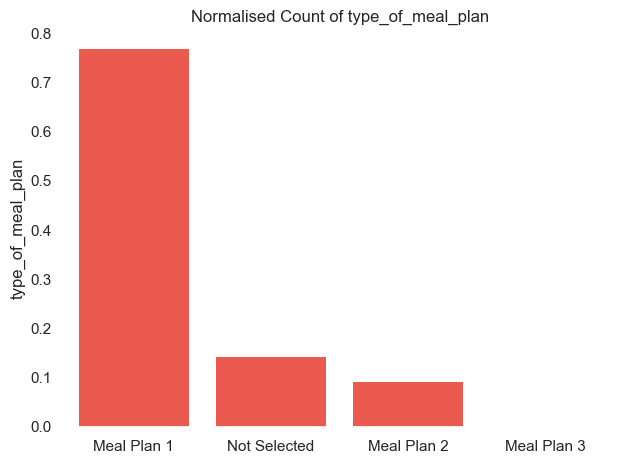

In [30]:
plot_categorical(hotel, "type_of_meal_plan")

In [31]:
cat_value_count(hotel, "room_type_reserved")

This categorical predictor has 7 unique values

                     abs_count  norm_count    cumsum  mean_target
room_type_reserved                                              
Room_Type 1           28130.0    0.775465  0.775465     0.322503
Room_Type 4            6057.0    0.166975  0.942440     0.341588
Room_Type 6             966.0    0.026630  0.969070     0.420290
Room_Type 2             692.0    0.019076  0.988146     0.329480
Room_Type 5             265.0    0.007305  0.995451     0.271698
Room_Type 7             158.0    0.004356  0.999807     0.227848
Room_Type 3               7.0    0.000193  1.000000     0.285714


In [32]:
cat_value_count(hotel, "market_segment_type")

This categorical predictor has 5 unique values

                      abs_count  norm_count    cumsum  mean_target
market_segment_type                                              
Online                 23214.0    0.639945  0.639945     0.365081
Offline                10528.0    0.290227  0.930172     0.299487
Corporate               2017.0    0.055603  0.985775     0.109073
Complementary            391.0    0.010779  0.996554     0.000000
Aviation                 125.0    0.003446  1.000000     0.296000


<a id='section3_3_2'></a>
#### 3.3.2. Feature Distribution

<a id='section3_3_2_1'></a>
##### 3.3.2.1. Univariate Analysis (Continuous features)

The analysis in this secction is meant to detect the presence and position of outliers with respect to the distribution of features.

In [33]:
(hotel
 .info()
)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36275 entries, 0 to 36274
Data columns (total 19 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Booking_ID                            36275 non-null  object 
 1   no_of_adults                          36275 non-null  int64  
 2   no_of_children                        36275 non-null  int64  
 3   no_of_weekend_nights                  36275 non-null  int64  
 4   no_of_week_nights                     36275 non-null  int64  
 5   type_of_meal_plan                     36275 non-null  object 
 6   required_car_parking_space            36275 non-null  int64  
 7   room_type_reserved                    36275 non-null  object 
 8   lead_time                             36275 non-null  int64  
 9   arrival_year                          36275 non-null  int64  
 10  arrival_month                         36275 non-null  int64  
 11  arrival_date   

In [34]:
print(f'Based on 1.5xIQR outlier detection formula:\n')
for col in ['no_of_adults', 'no_of_children', 'no_of_weekend_nights', 'no_of_week_nights', 'required_car_parking_space', 'lead_time', 'arrival_year', 'arrival_month', 'arrival_date', 'repeated_guest', 'no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled', 'avg_price_per_room', 'no_of_special_requests']:
    print(f'Column {col}: Detected total of {any_potential_outlier(hotel, col)} potential outliers')

Based on 1.5xIQR outlier detection formula:

Column no_of_adults: Detected total of 0 potential outliers
Column no_of_children: Detected total of 22 potential outliers
Column no_of_weekend_nights: Detected total of 21 potential outliers
Column no_of_week_nights: Detected total of 27 potential outliers
Column required_car_parking_space: Detected total of 1124 potential outliers
Column lead_time: Detected total of 0 potential outliers
Column arrival_year: Detected total of 0 potential outliers
Column arrival_month: Detected total of 0 potential outliers
Column arrival_date: Detected total of 0 potential outliers
Column repeated_guest: Detected total of 930 potential outliers
Column no_of_previous_cancellations: Detected total of 338 potential outliers
Column no_of_previous_bookings_not_canceled: Detected total of 812 potential outliers
Column avg_price_per_room: Detected total of 5 potential outliers
Column no_of_special_requests: Detected total of 0 potential outliers


<a id='section3_3_2_2'></a>
##### 3.3.2.2. Normality Check

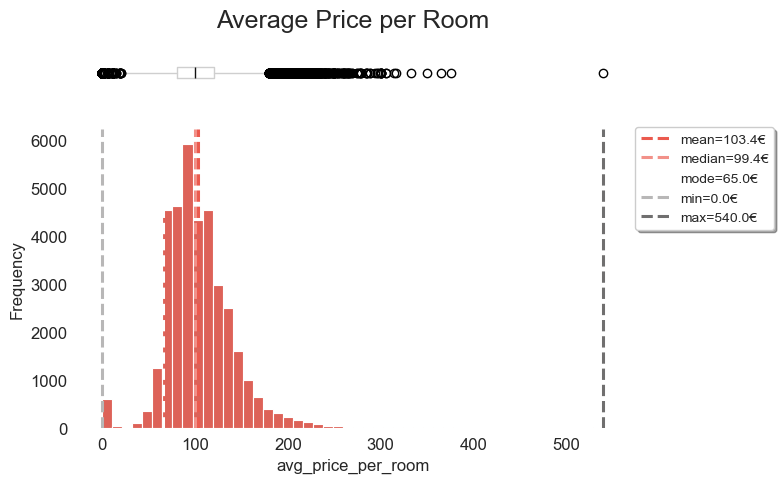

In [35]:
plot_continuous(hotel, 'avg_price_per_room', 'Average Price per Room', '€')

In [36]:
test_normality(hotel, 'avg_price_per_room')

Shapiro-Wilk Test (on sample data):
 Test Statistic: 0.9588992961016065
 p-value: 2.0021871066059338e-35

D'Agostino and Pearson's Test:
 Test Statistic: 4925.754960113978
 p-value: 0.0

At least one of the tests rejected the null hypothesis, suggesting the data is not normally distributed.


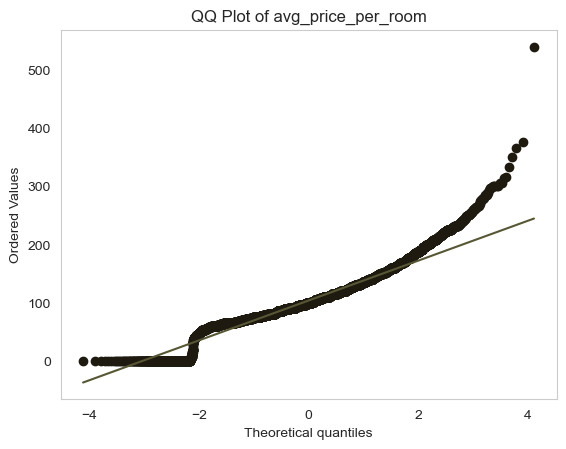

In [37]:
plot_qq(hotel, "avg_price_per_room")

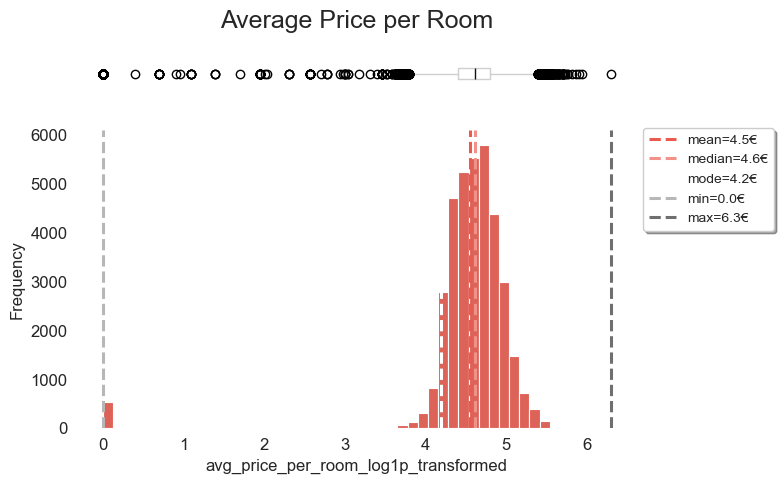

In [38]:
hotel['avg_price_per_room_log1p_transformed'] = np.log1p(hotel['avg_price_per_room'])
plot_continuous(hotel, 'avg_price_per_room_log1p_transformed', 'Average Price per Room', '€')

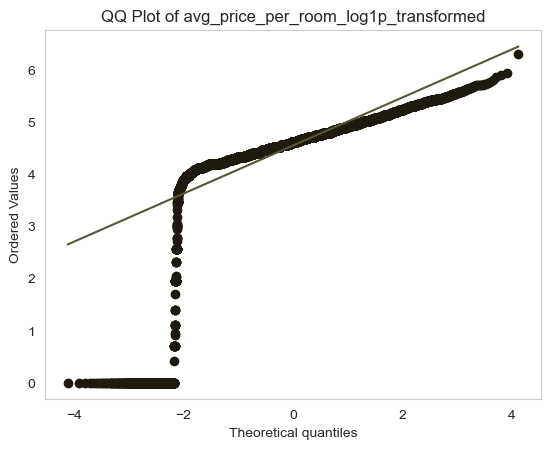

In [39]:
plot_qq(hotel, "avg_price_per_room_log1p_transformed")

Text(0.5, 1.0, 'Probplot after Yeo-Johnson transformation')

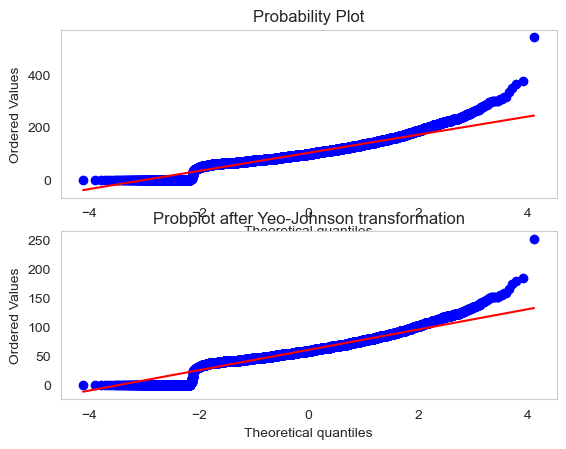

In [40]:
fig = plt.figure()
ax1 = fig.add_subplot(211)
prob = stats.probplot(hotel['avg_price_per_room'], dist=stats.norm, plot=ax1)

ax2 = fig.add_subplot(212)
xt, lmbda = stats.yeojohnson(hotel['avg_price_per_room'])
prob = stats.probplot(xt, dist=stats.norm, plot=ax2)

ax2.set_title('Probplot after Yeo-Johnson transformation')

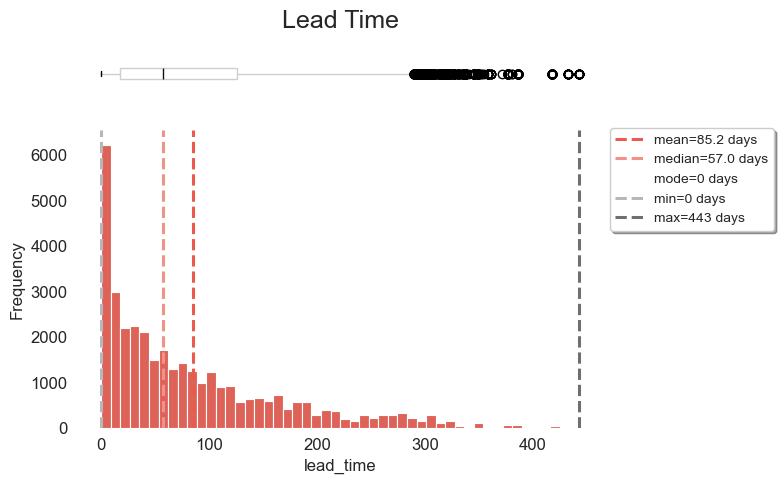

In [41]:
plot_continuous(hotel, 'lead_time', 'Lead Time', ' days')

In [42]:
test_normality(hotel, 'lead_time')

Shapiro-Wilk Test (on sample data):
 Test Statistic: 0.85478471983184
 p-value: 1.0765598537935964e-55

D'Agostino and Pearson's Test:
 Test Statistic: 7078.787074569272
 p-value: 0.0

At least one of the tests rejected the null hypothesis, suggesting the data is not normally distributed.


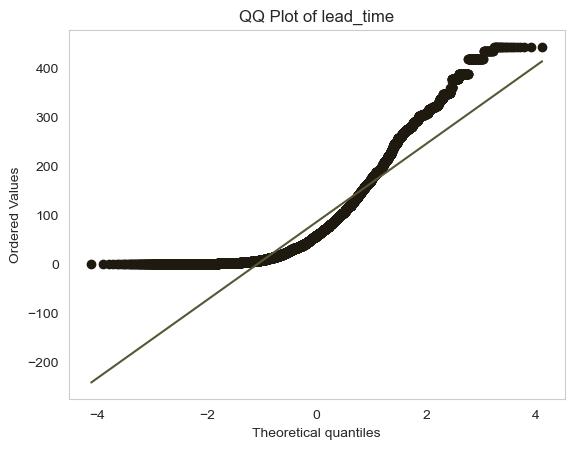

In [43]:
plot_qq(hotel, "lead_time")

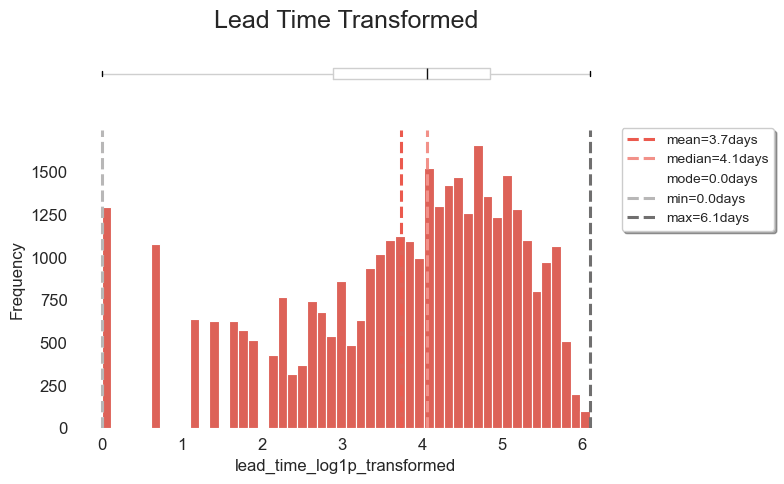

In [44]:
hotel['lead_time_log1p_transformed'] = np.log1p(hotel['lead_time'])
plot_continuous(hotel, 'lead_time_log1p_transformed', 'Lead Time Transformed', 'days')

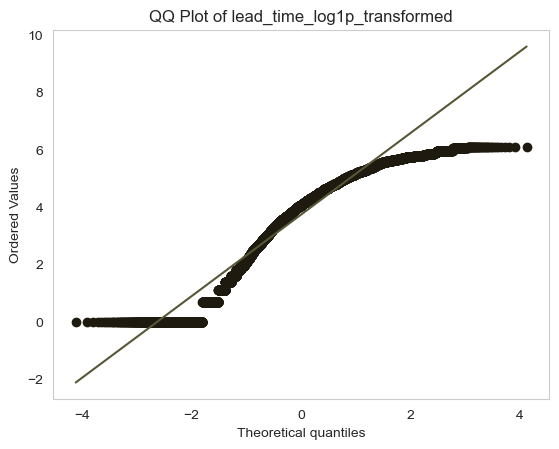

In [45]:
plot_qq(hotel, "lead_time_log1p_transformed")

Text(0.5, 1.0, 'Probplot after Yeo-Johnson transformation')

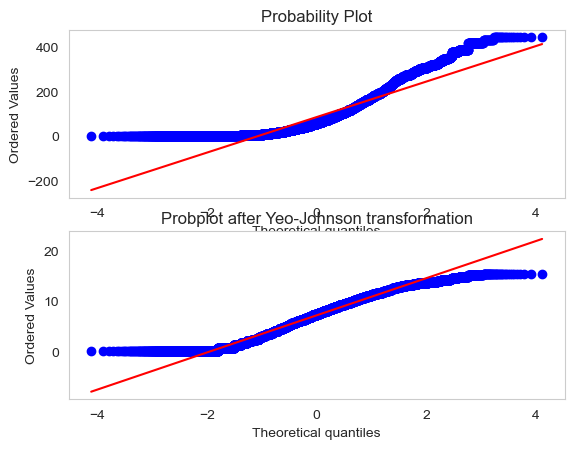

In [46]:
fig = plt.figure()
ax1 = fig.add_subplot(211)
prob = stats.probplot(hotel['lead_time'], dist=stats.norm, plot=ax1)

ax2 = fig.add_subplot(212)
xt, lmbda = stats.yeojohnson(hotel['lead_time'])
prob = stats.probplot(xt, dist=stats.norm, plot=ax2)

ax2.set_title('Probplot after Yeo-Johnson transformation')

<a id='section3_3_3'></a>
#### 3.3.3. Bivariate Analysis (Numerical Features v Target)

<a id='section3_3_3_1'></a>
##### 3.3.3.1. Bivariate Analysis (Numerical Features v Target Binary)

In [47]:
(hotel
 .select_dtypes('number')
 .corr(method='spearman')
 .style
 .background_gradient(cmap=cm, axis=None)
 .set_sticky(axis="index")
 .set_sticky(axis="columns")
)

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,required_car_parking_space,lead_time,arrival_year,arrival_month,arrival_date,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,avg_price_per_room_log1p_transformed,lead_time_log1p_transformed
no_of_adults,1.000000,0.029713,0.119551,0.136607,0.009649,0.166432,0.075419,0.006198,0.027400,-0.202869,-0.099709,-0.206596,0.283488,0.199253,0.283488,0.166432
no_of_children,0.029713,1.000000,0.031165,0.018637,0.032924,-0.025875,0.058753,-0.009459,0.029444,-0.037520,-0.026415,-0.033902,0.243964,0.135135,0.243964,-0.025875
no_of_weekend_nights,0.119551,0.031165,1.000000,0.018310,-0.030240,0.099491,0.058787,-0.009634,0.028728,-0.067933,-0.032250,-0.066075,-0.026429,0.065898,-0.026429,0.099491
no_of_week_nights,0.136607,0.018637,0.018310,1.000000,-0.054632,0.245444,0.032631,0.045280,-0.009624,-0.114454,-0.045158,-0.123036,0.018209,0.044925,0.018209,0.245444
required_car_parking_space,0.009649,0.032924,-0.030240,-0.054632,1.000000,-0.078732,0.015684,-0.016729,0.000077,0.110909,0.032409,0.118156,0.056357,0.094386,0.056357,-0.078732
lead_time,0.166432,-0.025875,0.099491,0.245444,-0.078732,1.000000,0.149966,0.081131,0.000242,-0.195886,-0.101156,-0.190897,-0.020530,-0.080659,-0.020530,1.000000
arrival_year,0.075419,0.058753,0.058787,0.032631,0.015684,0.149966,1.000000,-0.337851,0.018523,-0.018175,-0.043306,0.016720,0.188076,0.069210,0.188076,0.149966
arrival_month,0.006198,-0.009459,-0.009634,0.045280,-0.016729,0.081131,-0.337851,1.000000,-0.043323,0.010272,0.010889,-0.003410,0.016098,0.089749,0.016098,0.081131
arrival_date,0.027400,0.029444,0.028728,-0.009624,0.000077,0.000242,0.018523,-0.043323,1.000000,-0.015725,-0.017889,-0.006166,0.007212,0.020398,0.007212,0.000242
repeated_guest,-0.202869,-0.037520,-0.067933,-0.114454,0.110909,-0.195886,-0.018175,0.010272,-0.015725,1.000000,0.597867,0.932775,-0.177670,-0.013249,-0.177670,-0.195886


In [48]:
hotel.select_dtypes('number')

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,required_car_parking_space,lead_time,arrival_year,arrival_month,arrival_date,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,avg_price_per_room_log1p_transformed,lead_time_log1p_transformed
0,2,0,1,2,0,224,2017,10,2,0,0,0,65.00,0,4.189655,5.416100
1,2,0,2,3,0,5,2018,11,6,0,0,0,106.68,1,4.679164,1.791759
2,1,0,2,1,0,1,2018,2,28,0,0,0,60.00,0,4.110874,0.693147
3,2,0,0,2,0,211,2018,5,20,0,0,0,100.00,0,4.615121,5.356586
4,2,0,1,1,0,48,2018,4,11,0,0,0,94.50,0,4.559126,3.891820
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36270,3,0,2,6,0,85,2018,8,3,0,0,0,167.80,1,5.128715,4.454347
36271,2,0,1,3,0,228,2018,10,17,0,0,0,90.95,2,4.521245,5.433722
36272,2,0,2,6,0,148,2018,7,1,0,0,0,98.39,2,4.599052,5.003946
36273,2,0,0,3,0,63,2018,4,21,0,0,0,94.50,0,4.559126,4.158883


In [49]:
corrmat = hotel.select_dtypes('number').corr()
corrmat = corrmat.abs().unstack()
corrmat = corrmat.sort_values(ascending=False)
corrmat = corrmat[corrmat >= 0.5]
corrmat = corrmat[corrmat < 1]
corrmat = pd.DataFrame(corrmat).reset_index()
corrmat.columns = ['feature1', 'feature2', 'corr']

grouped_feature_ls = []
correlated_groups = []

for feature in corrmat.feature1.unique():
	if feature not in grouped_feature_ls:
		correlated_block = corrmat[corrmat.feature1 == feature]
		grouped_feature_ls = grouped_feature_ls + list(correlated_block.feature2.unique()) + [feature]
		correlated_groups.append(correlated_block)
  
correlated_groups

[    feature1                     feature2      corr
 0  lead_time  lead_time_log1p_transformed  0.810623,
                                feature1            feature2      corr
 2  avg_price_per_room_log1p_transformed  avg_price_per_room  0.747274,
                                feature1        feature2      corr
 4  no_of_previous_bookings_not_canceled  repeated_guest  0.539156]

In [50]:
(hotel
 .info()
)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36275 entries, 0 to 36274
Data columns (total 21 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Booking_ID                            36275 non-null  object 
 1   no_of_adults                          36275 non-null  int64  
 2   no_of_children                        36275 non-null  int64  
 3   no_of_weekend_nights                  36275 non-null  int64  
 4   no_of_week_nights                     36275 non-null  int64  
 5   type_of_meal_plan                     36275 non-null  object 
 6   required_car_parking_space            36275 non-null  int64  
 7   room_type_reserved                    36275 non-null  object 
 8   lead_time                             36275 non-null  int64  
 9   arrival_year                          36275 non-null  int64  
 10  arrival_month                         36275 non-null  int64  
 11  arrival_date   

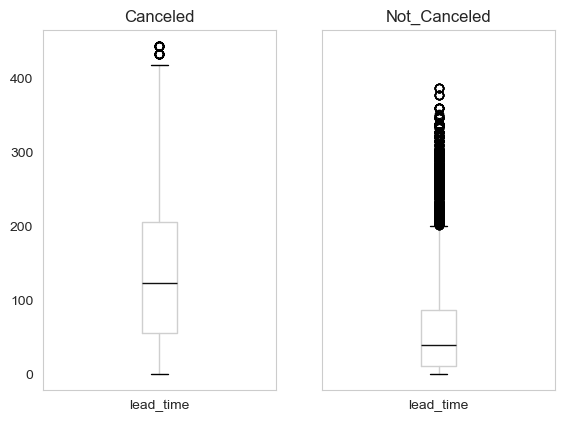

In [51]:
(hotel
 .groupby('booking_status')
 .boxplot(column=['lead_time'])
);

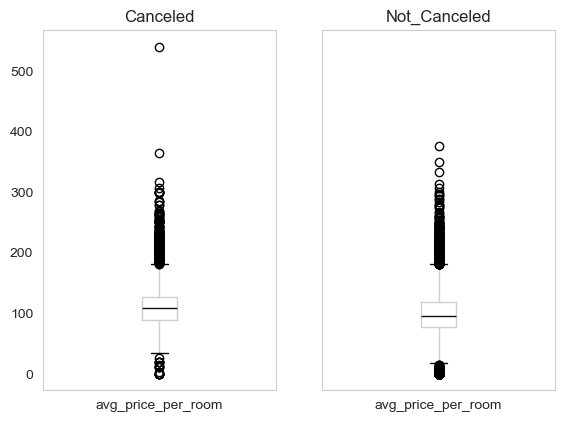

In [52]:
(hotel
 .groupby('booking_status')
 .boxplot(column=['avg_price_per_room'])
);

<a id='section3_3_3_2'></a>
##### 3.3.3.2. Bivariate Analysis (Categorical Features v Label)

In [53]:
(hotel
 .info()
)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36275 entries, 0 to 36274
Data columns (total 21 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Booking_ID                            36275 non-null  object 
 1   no_of_adults                          36275 non-null  int64  
 2   no_of_children                        36275 non-null  int64  
 3   no_of_weekend_nights                  36275 non-null  int64  
 4   no_of_week_nights                     36275 non-null  int64  
 5   type_of_meal_plan                     36275 non-null  object 
 6   required_car_parking_space            36275 non-null  int64  
 7   room_type_reserved                    36275 non-null  object 
 8   lead_time                             36275 non-null  int64  
 9   arrival_year                          36275 non-null  int64  
 10  arrival_month                         36275 non-null  int64  
 11  arrival_date   

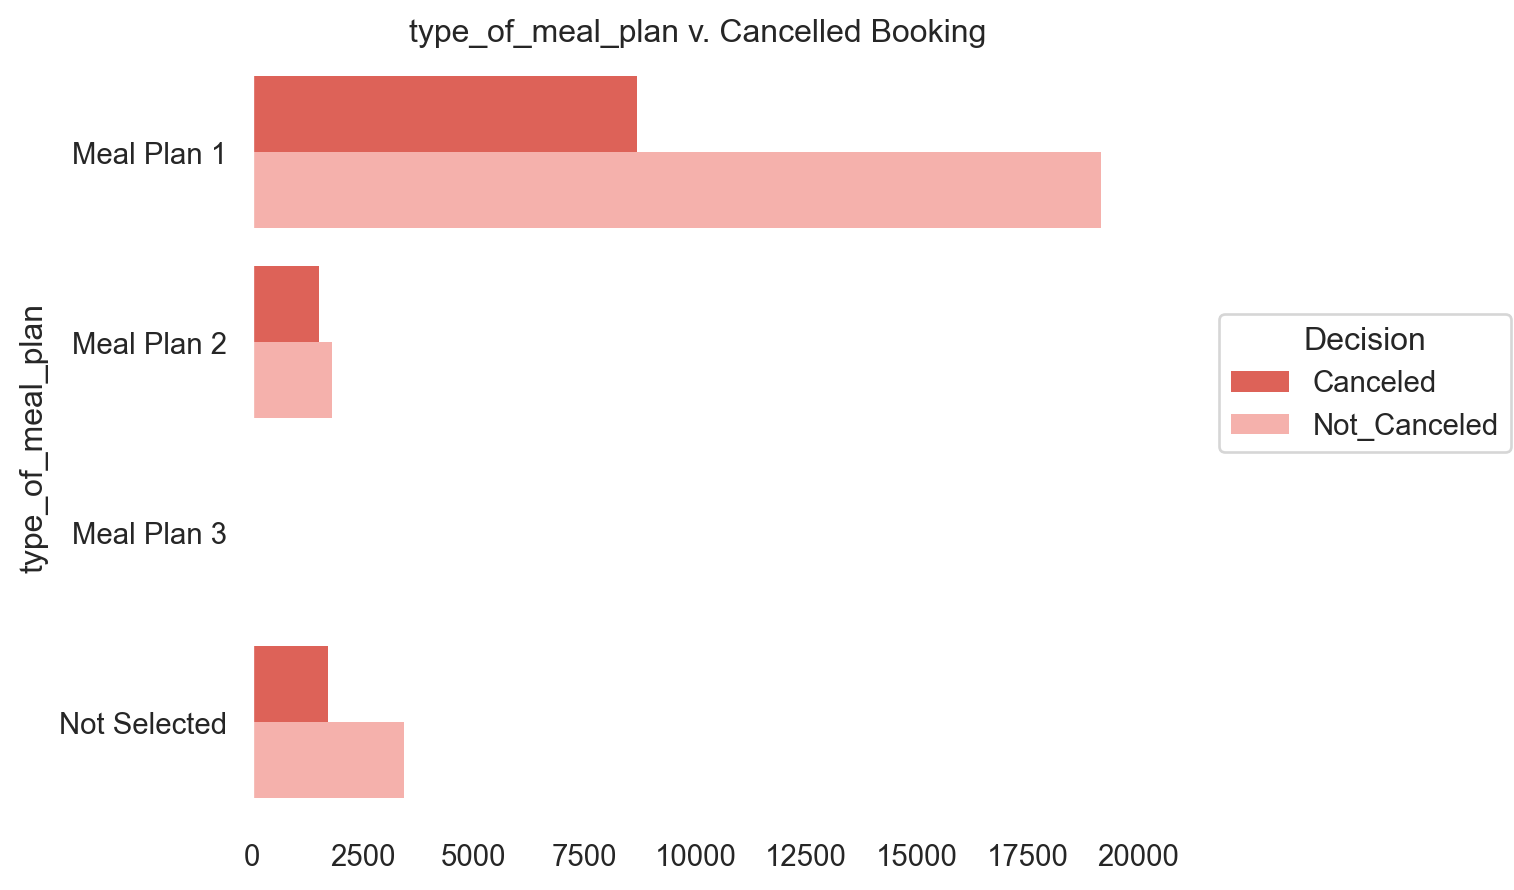

In [54]:
plot_features_label(hotel, "type_of_meal_plan")

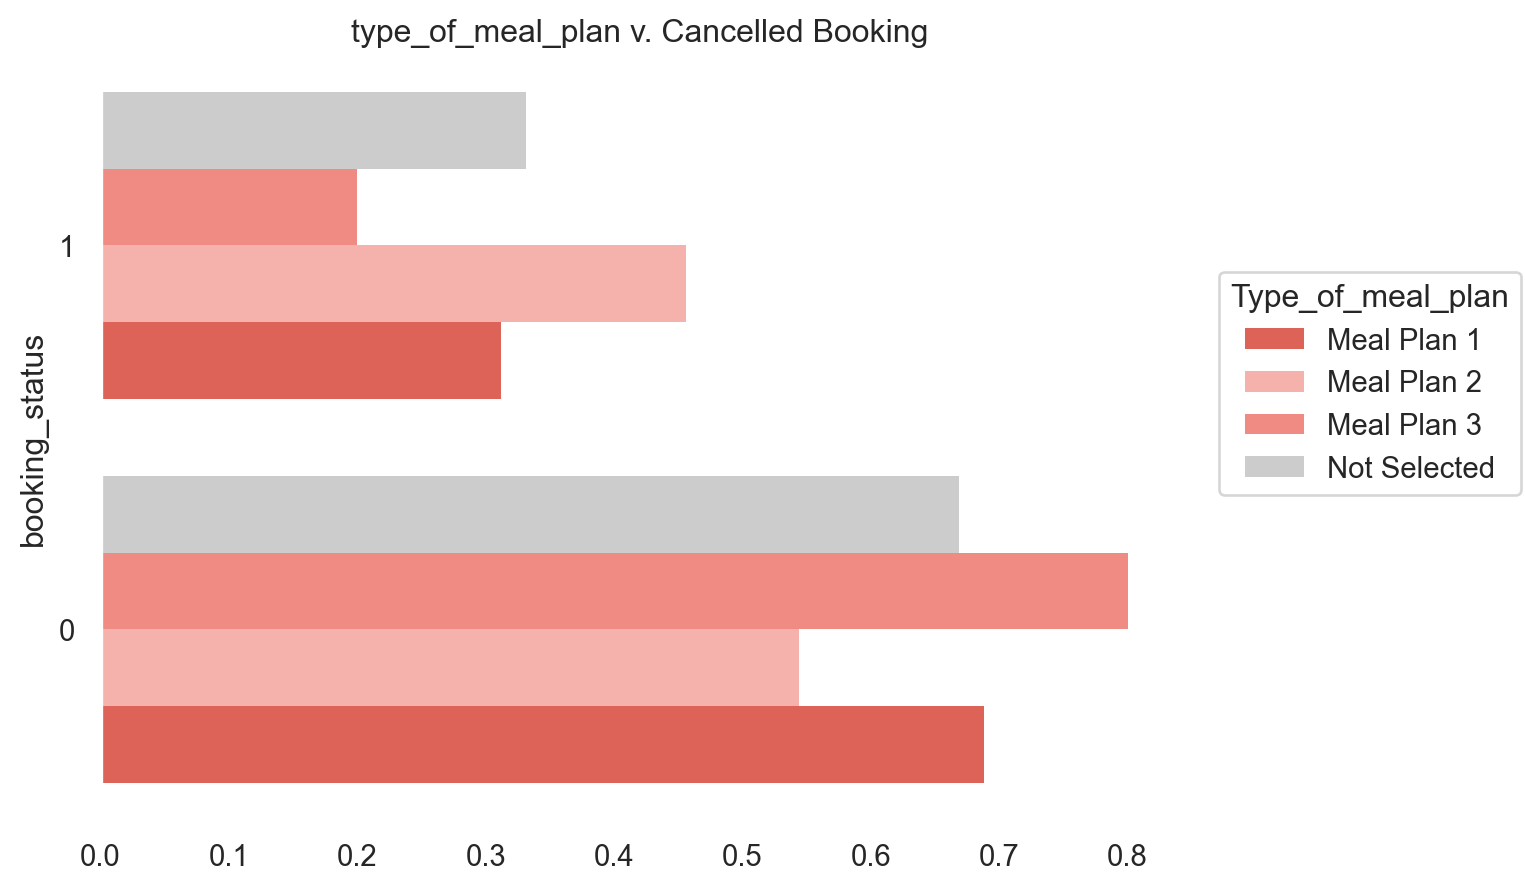

In [55]:
plot_label_features(hotel, "type_of_meal_plan")

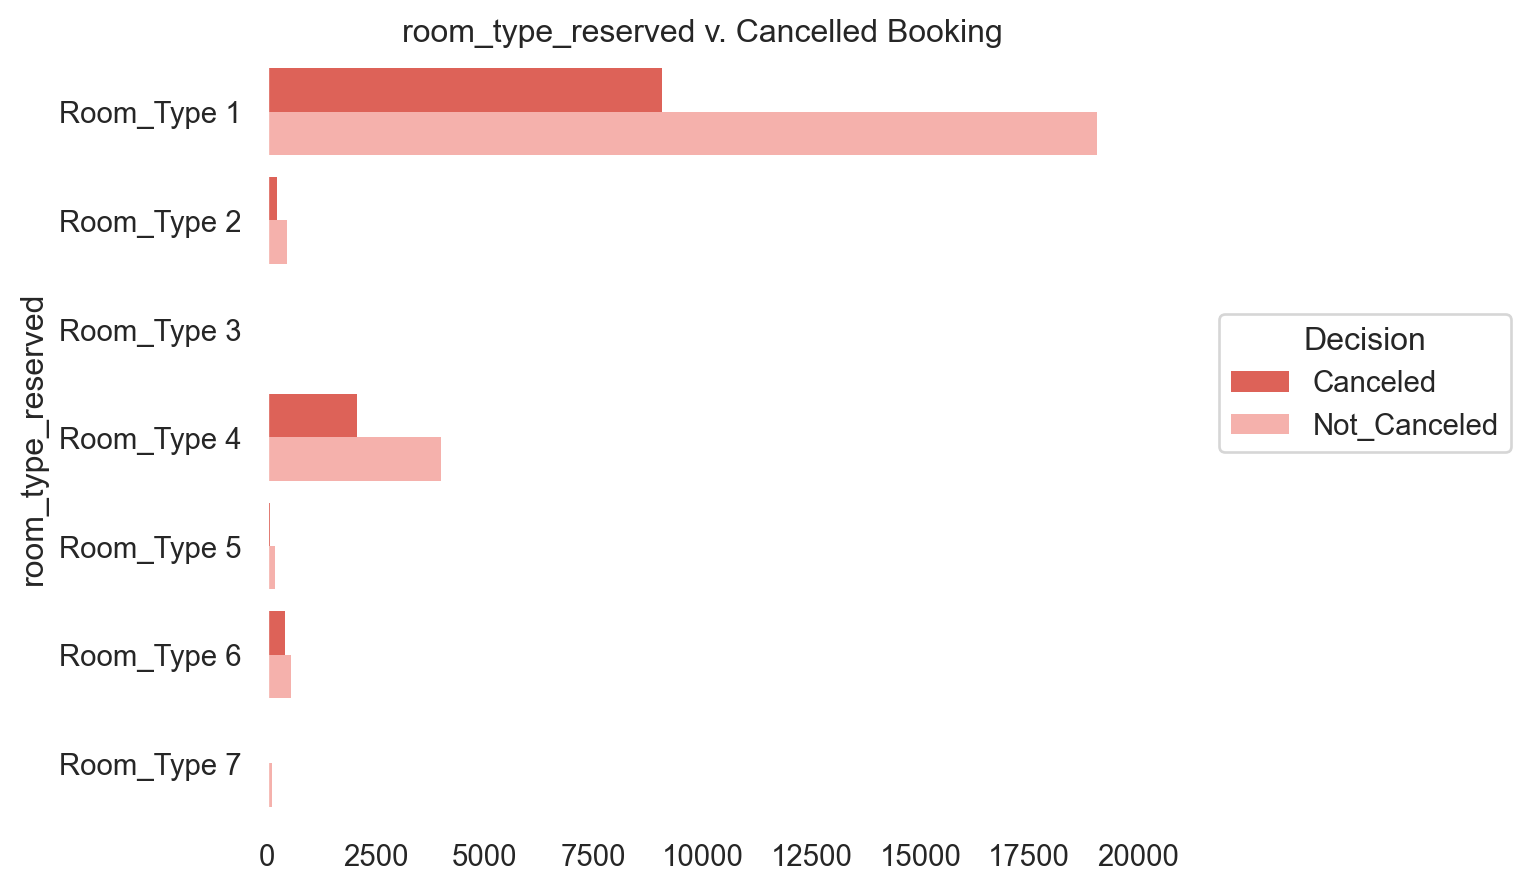

In [56]:
plot_features_label(hotel, "room_type_reserved")

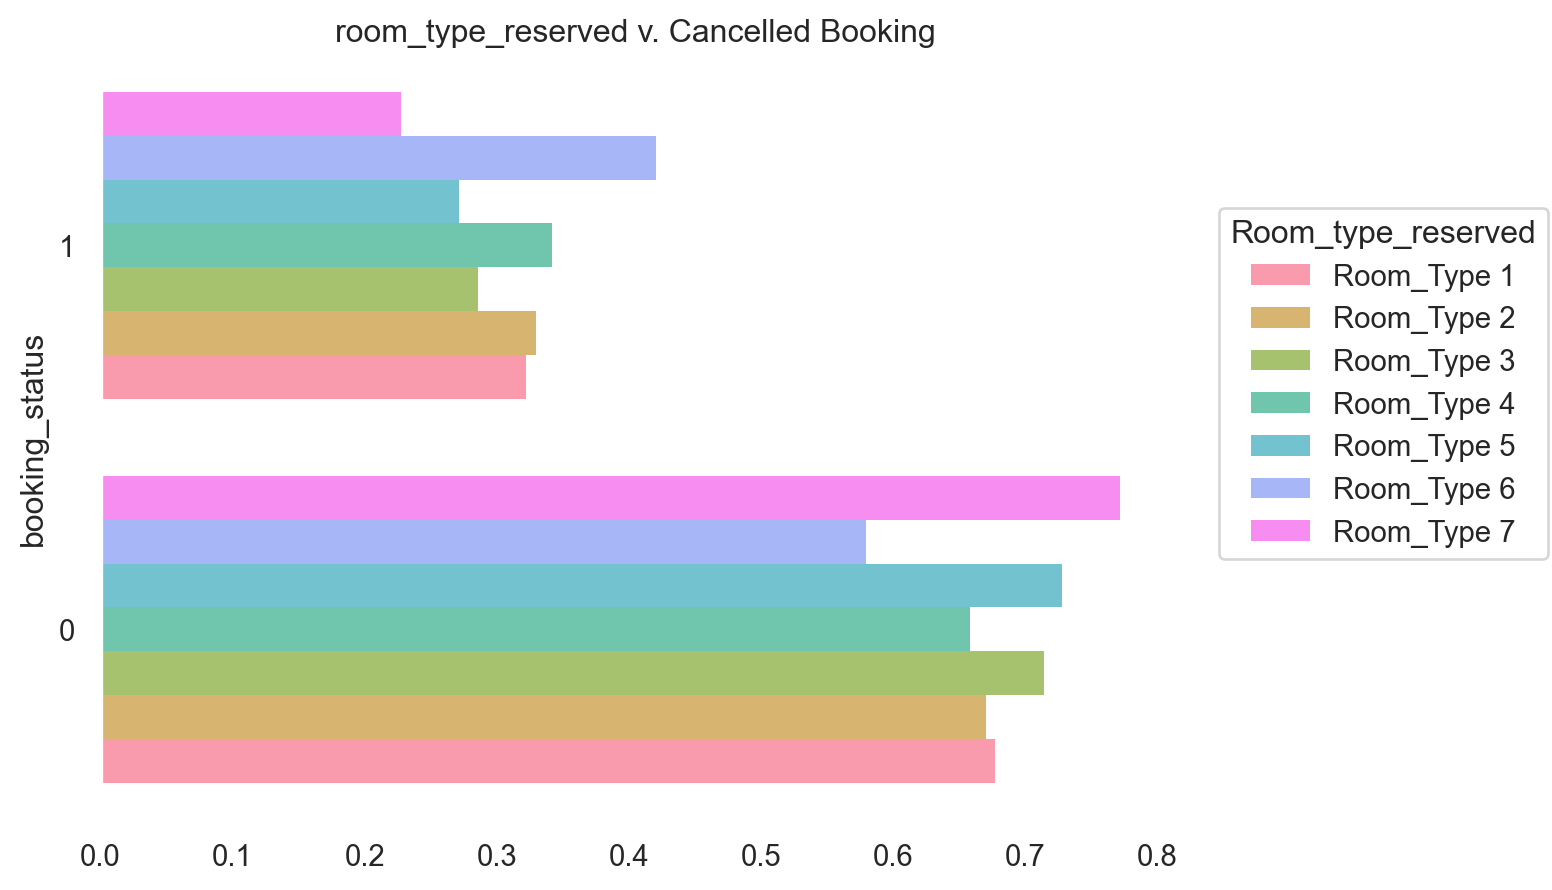

In [57]:
plot_label_features(hotel, "room_type_reserved")

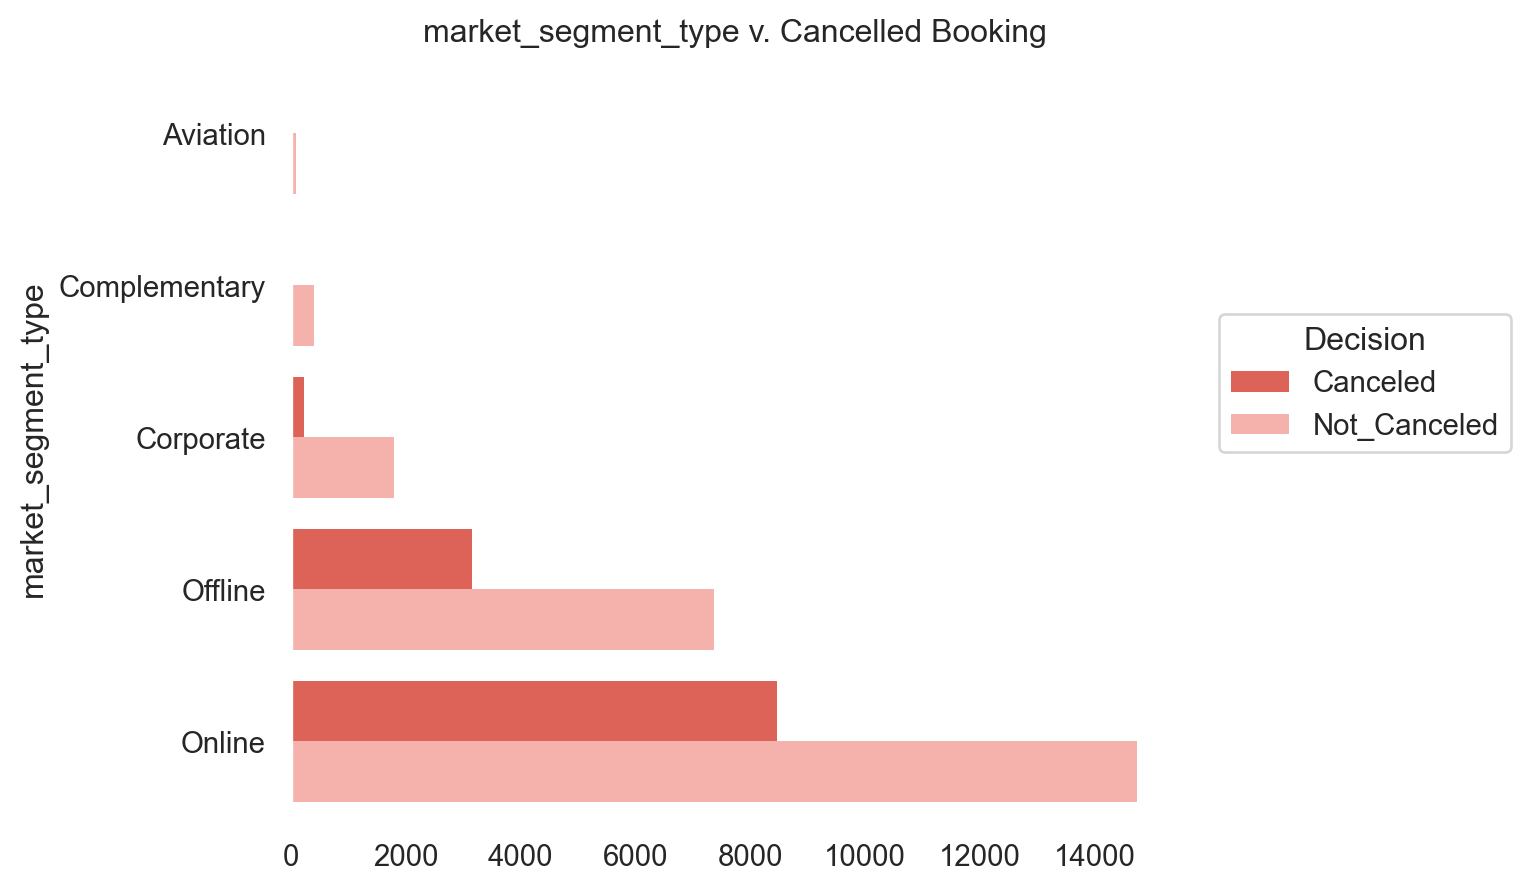

In [58]:
plot_features_label(hotel, "market_segment_type")

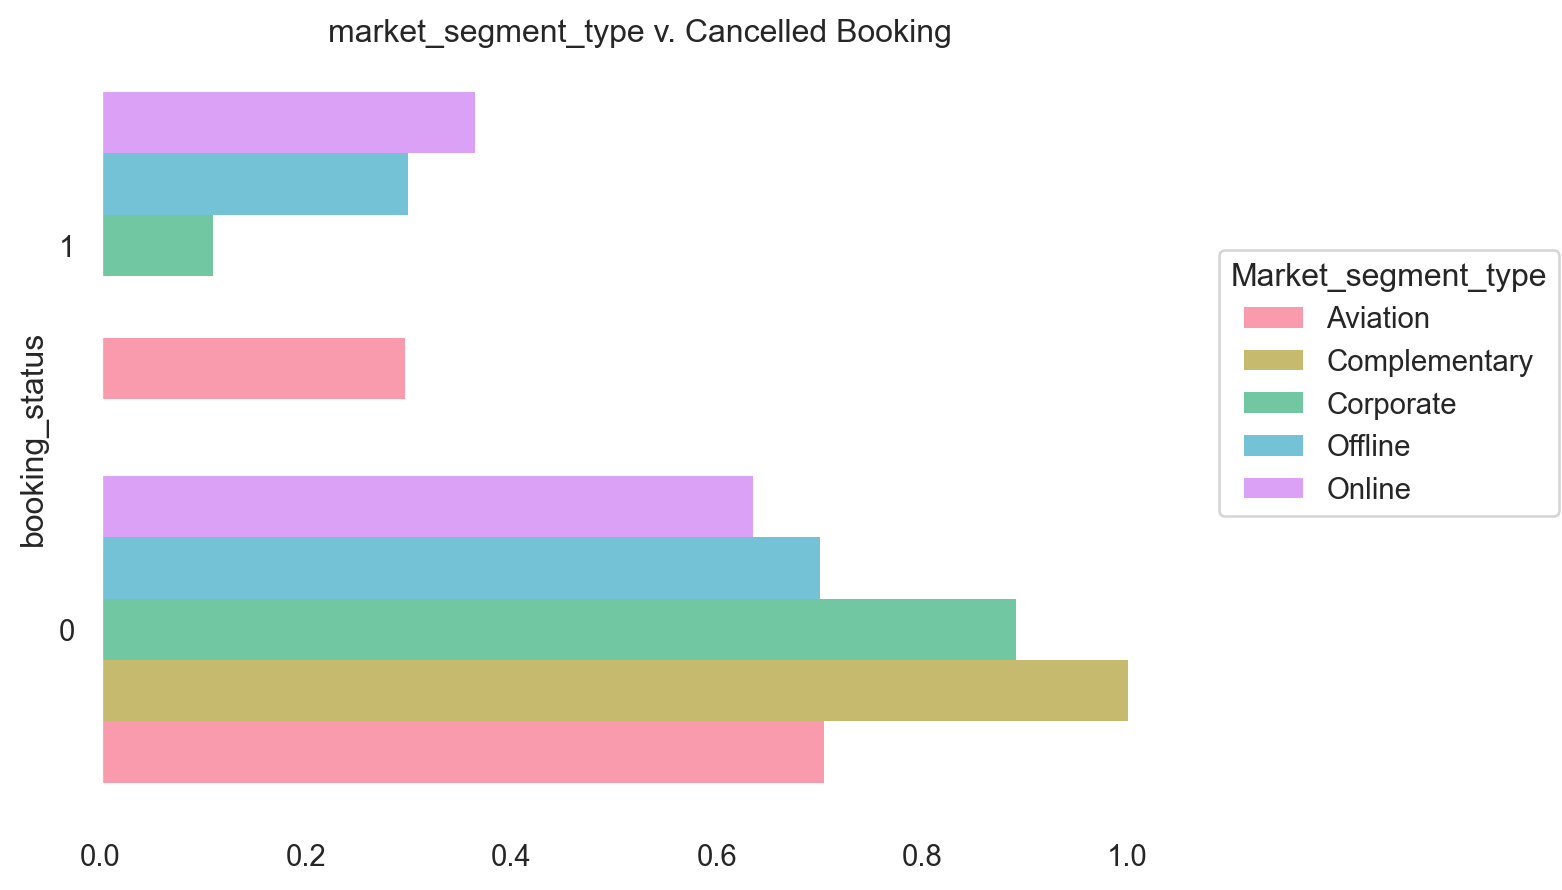

In [59]:
plot_label_features(hotel, "market_segment_type")

<a id='section3_3_3_3'></a>
##### 3.3.3.3. Bivariate Analysis (Relationship between features)

In [60]:
(hotel
 .info()
)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36275 entries, 0 to 36274
Data columns (total 21 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Booking_ID                            36275 non-null  object 
 1   no_of_adults                          36275 non-null  int64  
 2   no_of_children                        36275 non-null  int64  
 3   no_of_weekend_nights                  36275 non-null  int64  
 4   no_of_week_nights                     36275 non-null  int64  
 5   type_of_meal_plan                     36275 non-null  object 
 6   required_car_parking_space            36275 non-null  int64  
 7   room_type_reserved                    36275 non-null  object 
 8   lead_time                             36275 non-null  int64  
 9   arrival_year                          36275 non-null  int64  
 10  arrival_month                         36275 non-null  int64  
 11  arrival_date   

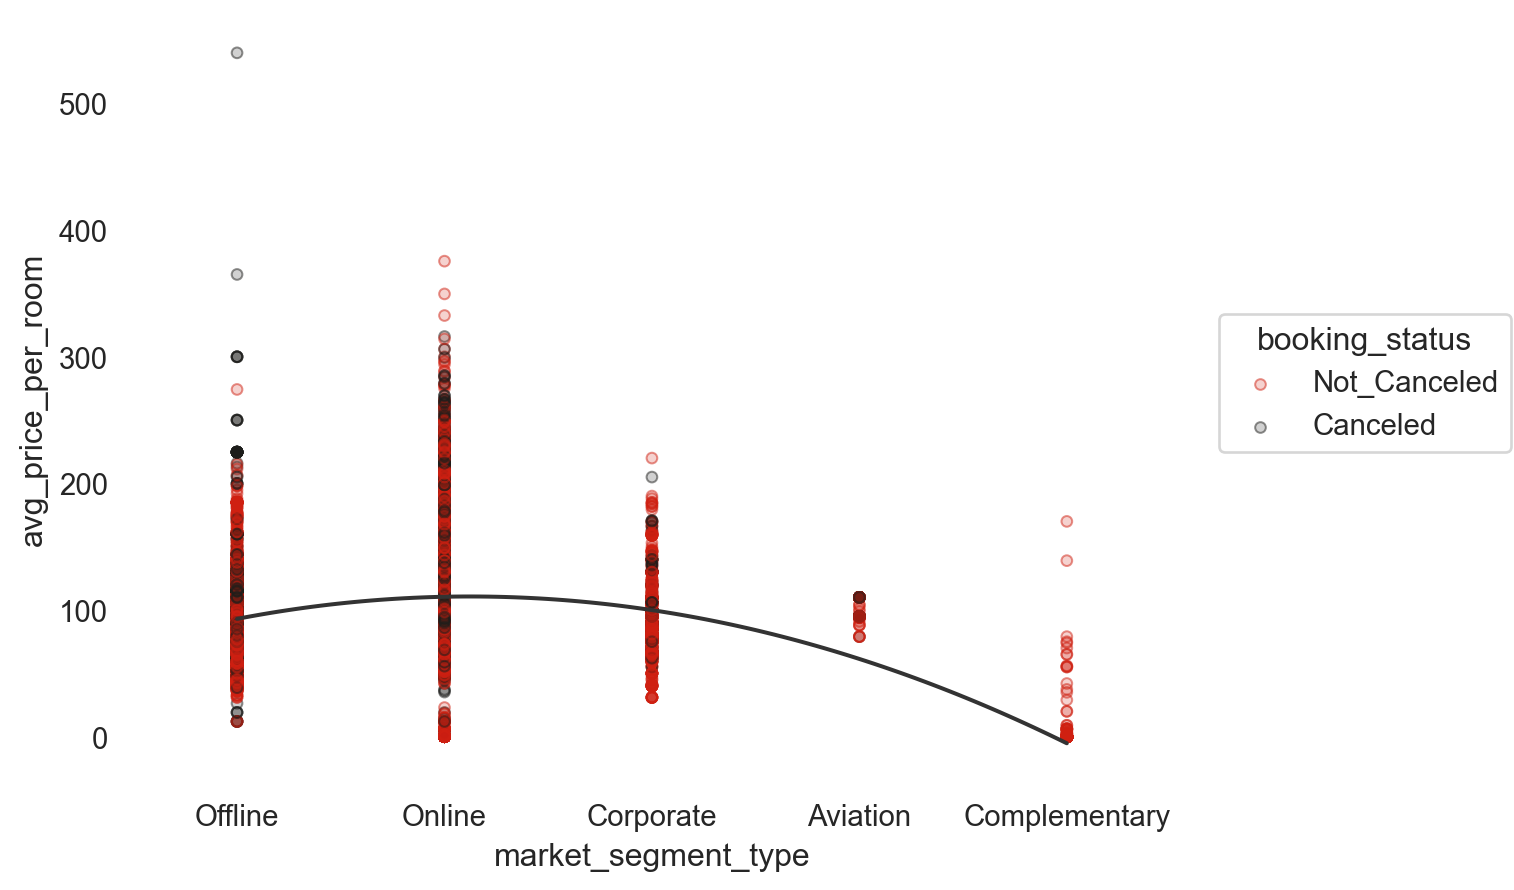

In [61]:
(so
 .Plot(hotel,
       x='market_segment_type',
       y='avg_price_per_room')
 .add(so.Dots(alpha=0.5),
      color='booking_status')
 .add(so.Line(color='.2'),
      so.PolyFit(),
      color=None)
 .scale(y=so.Continuous().tick(between=(0, 100)))
 .theme({"axes.prop_cycle": matplotlib.cycler(color=[color_palette[0], color_palette[7]]), "axes.facecolor": "w", "grid.color": "#ffffff"})
)

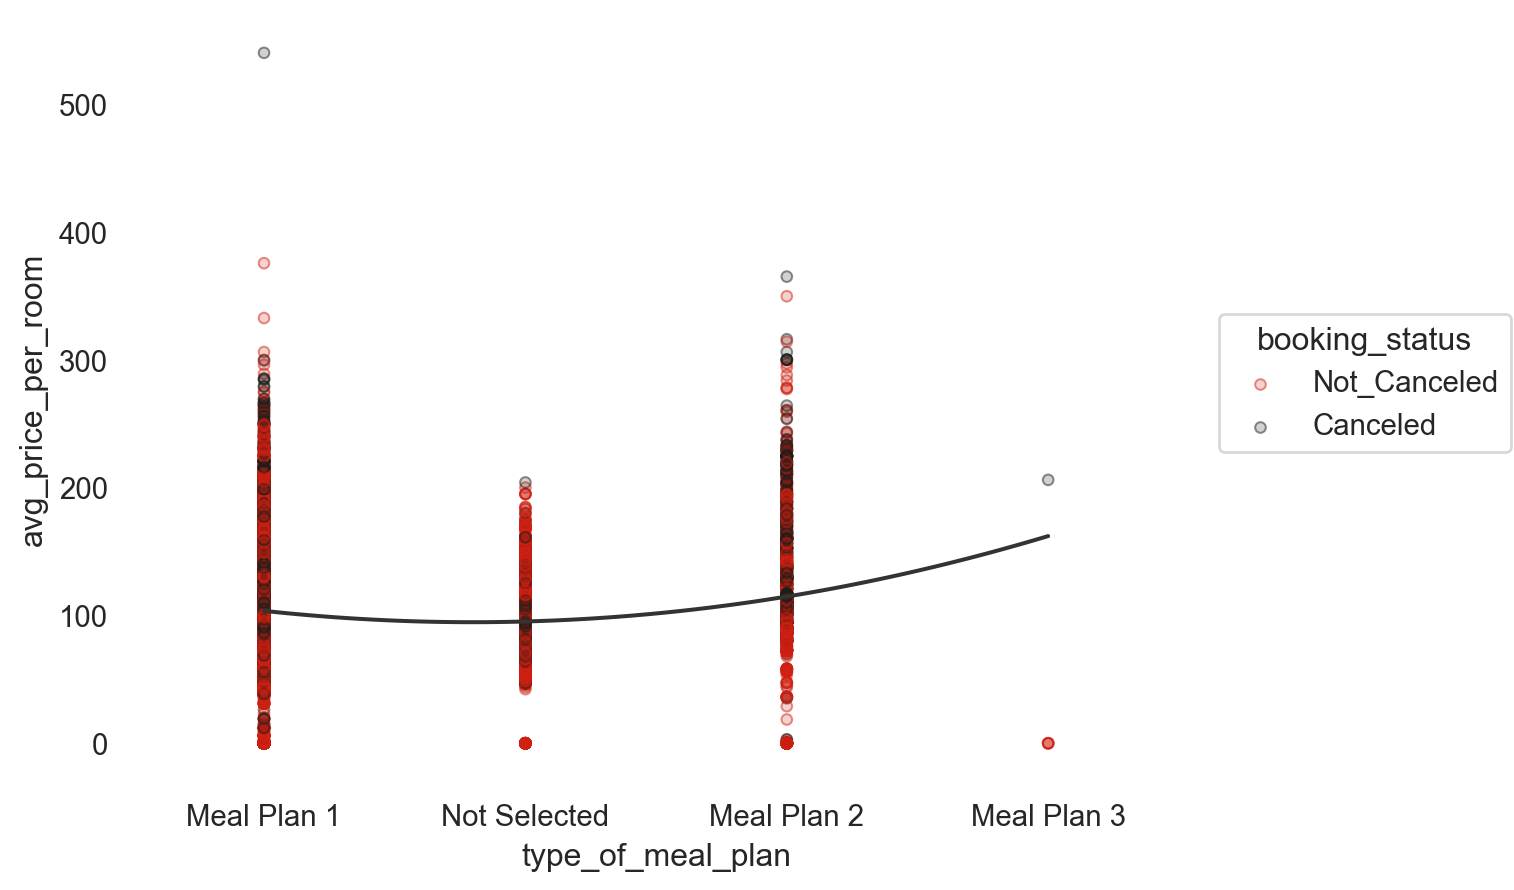

In [62]:
(so
 .Plot(hotel,
       x='type_of_meal_plan',
       y='avg_price_per_room')
 .add(so.Dots(alpha=0.5),
      color='booking_status')
 .add(so.Line(color='.2'),
      so.PolyFit(),
      color=None)
 .scale(y=so.Continuous().tick(between=(0, 100)))
 .theme({"axes.prop_cycle": matplotlib.cycler(color=[color_palette[0], color_palette[7]]), "axes.facecolor": "w", "grid.color": "#ffffff"})
)

In [63]:
(hotel
 .groupby(['room_type_reserved', 'type_of_meal_plan'])
 ['type_of_meal_plan']
 .describe()
 ["count"]
 .unstack(level=1)
 .reset_index()
 .melt(id_vars='room_type_reserved', var_name='type_of_meal_plan', value_name='count'))

,room_type_reserved,type_of_meal_plan,count
0,Room_Type 1,Meal Plan 1,20157
1,Room_Type 2,Meal Plan 1,653
2,Room_Type 3,Meal Plan 1,5
3,Room_Type 4,Meal Plan 1,5748
4,Room_Type 5,Meal Plan 1,242
5,Room_Type 6,Meal Plan 1,878
6,Room_Type 7,Meal Plan 1,152
7,Room_Type 1,Meal Plan 2,2934
8,Room_Type 2,Meal Plan 2,16
9,Room_Type 3,Meal Plan 2,NaN


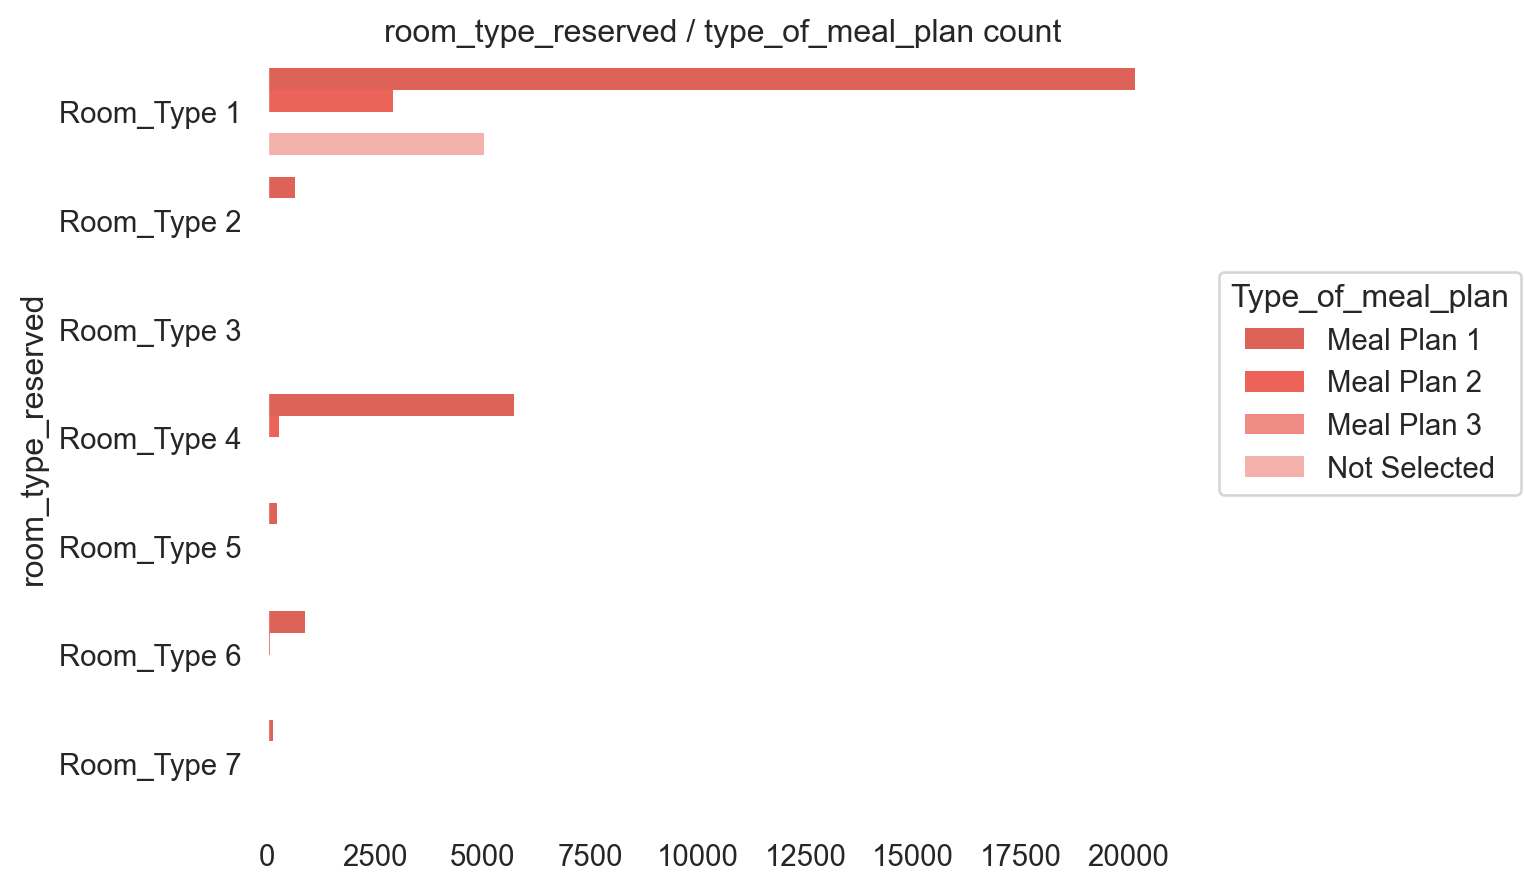

In [64]:
(so
 .Plot((hotel
 .groupby(['room_type_reserved', 'type_of_meal_plan'])
 ['type_of_meal_plan']
 .describe()
 ["count"]
 .unstack(level=1)
 .reset_index()
 .melt(id_vars='room_type_reserved', var_name='type_of_meal_plan', value_name='count')
 .astype({'count': 'float16'})),
       x='count',
       y='room_type_reserved',
       color='type_of_meal_plan')
 .add(so.Bar(edgewidth=0),
      so.Agg(),
      so.Dodge())
 .label(x='',
        y='room_type_reserved',
        color=str.capitalize,
        title=f'room_type_reserved / type_of_meal_plan count')
 .theme({"axes.prop_cycle": matplotlib.cycler(color=color_palette), "axes.facecolor": "w", "grid.color": "#ffffff"})
)

In [65]:
# hotel = hotel.assign(booking_status=np.where(hotel['booking_status'] == "Not_Canceled", 0, 1))
df_cat = pd.concat([hotel.select_dtypes('object').drop(columns=['Booking_ID', 'booking_status']), hotel['booking_status']], axis=1)

label = LabelEncoder()
df_encoded = pd.DataFrame()

for i in df_cat.columns:
    if i != "booking_status":
        df_encoded[i] = label.fit_transform(df_cat[i])
    else:
        df_encoded[i] = label.fit_transform(df_cat[i].values.ravel())
    
def Cramers_V(var1, var2):
    crosstab = np.array(pd.crosstab(index=var1, columns=var2)) # Cross Tab
    return (association(crosstab, method='cramer'))            # Return Cramer's V

# Create the dataFrame matrix with the returned Cramer's V
rows = []

for var1 in df_encoded:
    col = []

    for var2 in df_encoded:
        V = Cramers_V(df_encoded[var1], df_encoded[var2]) # Return Cramer's V
        col.append(V)                                             # Store values to subsequent columns  
        
    rows.append(col)                                              # Store values to subsequent rows
    
CramersV_results = np.array(rows)
CramersV_df = (pd
               .DataFrame(CramersV_results, columns = df_encoded.columns, index = df_encoded.columns)
               .style
               .background_gradient(cmap=cm, axis=None)
               .set_sticky(axis="index")
               .set_sticky(axis="columns"))
CramersV_df

,type_of_meal_plan,room_type_reserved,market_segment_type,booking_status
type_of_meal_plan,1.000000,0.146975,0.228923,0.087589
room_type_reserved,0.146975,1.000000,0.165002,0.039756
market_segment_type,0.228923,0.165002,1.000000,0.149809
booking_status,0.087589,0.039756,0.149809,1.000000


In [67]:
hotel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36275 entries, 0 to 36274
Data columns (total 21 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Booking_ID                            36275 non-null  object 
 1   no_of_adults                          36275 non-null  int64  
 2   no_of_children                        36275 non-null  int64  
 3   no_of_weekend_nights                  36275 non-null  int64  
 4   no_of_week_nights                     36275 non-null  int64  
 5   type_of_meal_plan                     36275 non-null  object 
 6   required_car_parking_space            36275 non-null  int64  
 7   room_type_reserved                    36275 non-null  object 
 8   lead_time                             36275 non-null  int64  
 9   arrival_year                          36275 non-null  int64  
 10  arrival_month                         36275 non-null  int64  
 11  arrival_date   

In [117]:
def tweak_hotel(df: pd.DataFrame) -> pd.DataFrame:
    
    leap_year_error = (df
                       .loc[(df['arrival_year'] == 2018) & (df['arrival_month'] == 2) & (df['arrival_date'] == 29)]
                       .index)
    return (df
            .astype({**{k: 'int8' 
                        for k in ['no_of_adults', 'no_of_children', 'no_of_weekend_nights', 'no_of_week_nights', 'required_car_parking_space', 'repeated_guest', 'no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled', 'no_of_special_requests']},
                     **{k: 'int16'
                        for k in ['lead_time']},
                     **{k: 'category'
                        for k in ['type_of_meal_plan', 'room_type_reserved', 'market_segment_type',]},
                     **{k: 'str'
                        for k in ['arrival_date', 'arrival_month', 'arrival_year']},
                     'avg_price_per_room': 'float16'})
            # .drop(columns=['Booking_ID'])
            .drop(leap_year_error)
            .assign(date_combined=lambda df_: pd.to_datetime(df_['arrival_year'] + '-' + df_['arrival_month'] + '-' + df_['arrival_date']),
                    lead_time_category=lambda df_: np.where(df_['lead_time'] < 90, 'Within 3 months', np.where(df_['lead_time'] < 180, 'Within 6 months', 'Beyond 6 months')),
                    is_weekend_arrival=lambda df_: np.where(pd.to_datetime(df_['arrival_year'] + '-' + df_['arrival_month'] + '-' + df_['arrival_date']).dt.weekday > 5, 1, 0),
                    quarter=lambda df_: pd.to_datetime(df_['arrival_year'] + '-' + df_['arrival_month'] + '-' + df_['arrival_date']).dt.quarter,
                    total_people=lambda df_: df_['no_of_adults'] + df_['no_of_children'],
                    is_alone=lambda df_: np.where(df_['total_people'] == 1, 1, 0),
                    booking_status=lambda df_: df_["booking_status"].map({"Not_Canceled": 0, "Canceled": 1}))
            )

In [118]:
tweak_hotel(hotel)

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status,avg_price_per_room_log1p_transformed,lead_time_log1p_transformed,date_combined,lead_time_category,is_weekend_arrival,quarter,total_people,is_alone
0,INN00001,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,2017,10,2,Offline,0,0,0,65.0000,0,0,4.189655,5.416100,2017-10-02,Beyond 6 months,0,4,2,0
1,INN00002,2,0,2,3,Not Selected,0,Room_Type 1,5,2018,11,6,Online,0,0,0,106.6875,1,0,4.679164,1.791759,2018-11-06,Within 3 months,0,4,2,0
2,INN00003,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,2018,2,28,Online,0,0,0,60.0000,0,1,4.110874,0.693147,2018-02-28,Within 3 months,0,1,1,1
3,INN00004,2,0,0,2,Meal Plan 1,0,Room_Type 1,211,2018,5,20,Online,0,0,0,100.0000,0,1,4.615121,5.356586,2018-05-20,Beyond 6 months,1,2,2,0
4,INN00005,2,0,1,1,Not Selected,0,Room_Type 1,48,2018,4,11,Online,0,0,0,94.5000,0,1,4.559126,3.891820,2018-04-11,Within 3 months,0,2,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36270,INN36271,3,0,2,6,Meal Plan 1,0,Room_Type 4,85,2018,8,3,Online,0,0,0,167.7500,1,0,5.128715,4.454347,2018-08-03,Within 3 months,0,3,3,0
36271,INN36272,2,0,1,3,Meal Plan 1,0,Room_Type 1,228,2018,10,17,Online,0,0,0,90.9375,2,1,4.521245,5.433722,2018-10-17,Beyond 6 months,0,4,2,0
36272,INN36273,2,0,2,6,Meal Plan 1,0,Room_Type 1,148,2018,7,1,Online,0,0,0,98.3750,2,0,4.599052,5.003946,2018-07-01,Within 6 months,1,3,2,0
36273,INN36274,2,0,0,3,Not Selected,0,Room_Type 1,63,2018,4,21,Online,0,0,0,94.5000,0,1,4.559126,4.158883,2018-04-21,Within 3 months,0,2,2,0


In [89]:
(tweak_hotel(hotel)
 .groupby(by=['date_combined'])
 .agg({'Booking_ID': 'count'})
 .reset_index()
 )

,date_combined,Booking_ID
0,2017-07-01,68
1,2017-07-02,5
2,2017-07-03,3
3,2017-07-04,4
4,2017-07-05,3
...,...,...
544,2018-12-27,147
545,2018-12-28,84
546,2018-12-29,105
547,2018-12-30,93


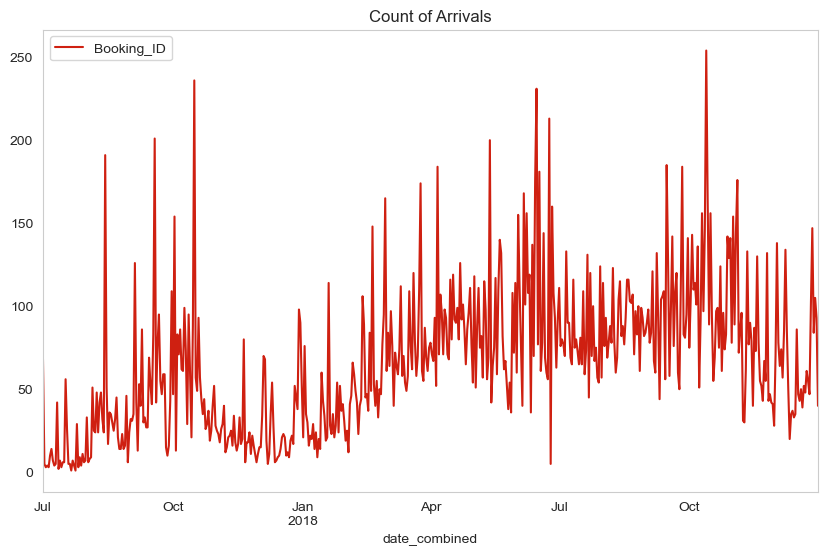

In [90]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
(tweak_hotel(hotel)
 .groupby(by=['date_combined'])
 .agg({'Booking_ID': 'count'})
 .plot
 .line(ax=ax, title='Count of Arrivals')
 );

In [91]:
(tweak_hotel(hotel))

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status,avg_price_per_room_log1p_transformed,lead_time_log1p_transformed,date_combined,lead_time_category,is_weekend_arrival,total_people,is_alone
0,INN00001,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,2017,10,2,Offline,0,0,0,65.0000,0,0,4.189655,5.416100,2017-10-02,Beyond 6 months,0,2,0
1,INN00002,2,0,2,3,Not Selected,0,Room_Type 1,5,2018,11,6,Online,0,0,0,106.6875,1,0,4.679164,1.791759,2018-11-06,Within 3 months,0,2,0
2,INN00003,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,2018,2,28,Online,0,0,0,60.0000,0,1,4.110874,0.693147,2018-02-28,Within 3 months,0,1,1
3,INN00004,2,0,0,2,Meal Plan 1,0,Room_Type 1,211,2018,5,20,Online,0,0,0,100.0000,0,1,4.615121,5.356586,2018-05-20,Beyond 6 months,1,2,0
4,INN00005,2,0,1,1,Not Selected,0,Room_Type 1,48,2018,4,11,Online,0,0,0,94.5000,0,1,4.559126,3.891820,2018-04-11,Within 3 months,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36270,INN36271,3,0,2,6,Meal Plan 1,0,Room_Type 4,85,2018,8,3,Online,0,0,0,167.7500,1,0,5.128715,4.454347,2018-08-03,Within 3 months,0,3,0
36271,INN36272,2,0,1,3,Meal Plan 1,0,Room_Type 1,228,2018,10,17,Online,0,0,0,90.9375,2,1,4.521245,5.433722,2018-10-17,Beyond 6 months,0,2,0
36272,INN36273,2,0,2,6,Meal Plan 1,0,Room_Type 1,148,2018,7,1,Online,0,0,0,98.3750,2,0,4.599052,5.003946,2018-07-01,Within 6 months,1,2,0
36273,INN36274,2,0,0,3,Not Selected,0,Room_Type 1,63,2018,4,21,Online,0,0,0,94.5000,0,1,4.559126,4.158883,2018-04-21,Within 3 months,0,2,0


In [95]:
(tweak_hotel(hotel)
 .groupby(by=['date_combined'])
 ['booking_status']
 .mean()
)

date_combined
2017-07-01    0.764706
2017-07-02    1.000000
2017-07-03    0.666667
2017-07-04    1.000000
2017-07-05    1.000000
                ...   
2018-12-27    0.170068
2018-12-28    0.250000
2018-12-29    0.209524
2018-12-30    0.204301
2018-12-31    0.250000
Name: booking_status, Length: 549, dtype: float64

In [96]:
(tweak_hotel(hotel)
 .loc[lambda df_: df_['date_combined'] == '2017-07-02']
)

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status,avg_price_per_room_log1p_transformed,lead_time_log1p_transformed,date_combined,lead_time_category,is_weekend_arrival,total_people,is_alone
7236,INN07237,2,0,2,3,Meal Plan 1,0,Room_Type 1,62,2017,7,2,Online,0,0,0,76.5,1,1,4.350278,4.143135,2017-07-02,Within 3 months,1,2,0
10934,INN10935,1,0,1,3,Meal Plan 1,0,Room_Type 1,63,2017,7,2,Online,0,0,0,68.0,0,1,4.234107,4.158883,2017-07-02,Within 3 months,1,1,1
12316,INN12317,2,0,0,2,Meal Plan 1,0,Room_Type 1,100,2017,7,2,Online,0,0,0,76.5,1,1,4.350278,4.615121,2017-07-02,Within 6 months,1,2,0
24262,INN24263,2,0,0,3,Meal Plan 1,0,Room_Type 1,79,2017,7,2,Online,0,0,0,76.5,1,1,4.350278,4.382027,2017-07-02,Within 3 months,1,2,0
28361,INN28362,2,0,2,3,Meal Plan 1,0,Room_Type 1,62,2017,7,2,Online,0,0,0,76.5,1,1,4.350278,4.143135,2017-07-02,Within 3 months,1,2,0


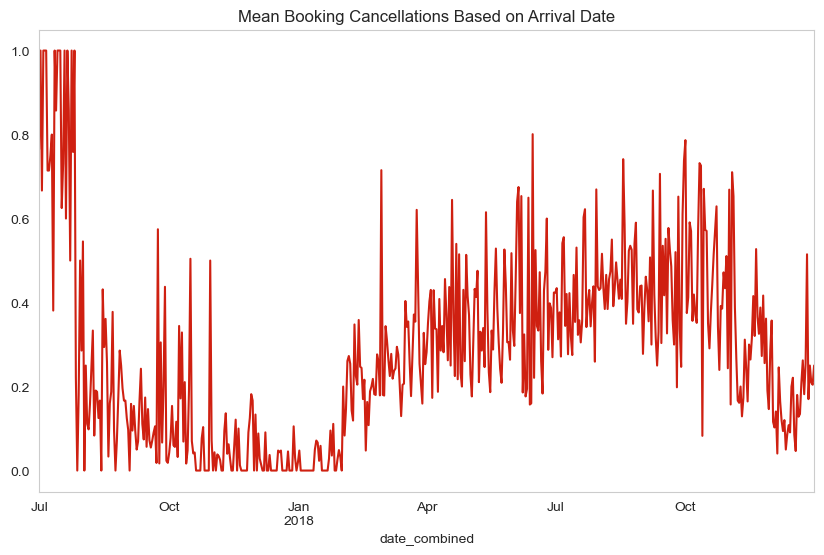

In [97]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
(tweak_hotel(hotel)
 .groupby(by=['date_combined'])
 ['booking_status']
 .mean()
 .plot
 .line(ax=ax, title='Mean Booking Cancellations Based on Arrival Date')
 );

<Axes: title={'center': 'month Distribution'}, xlabel='arrival_month', ylabel='Booking_ID'>

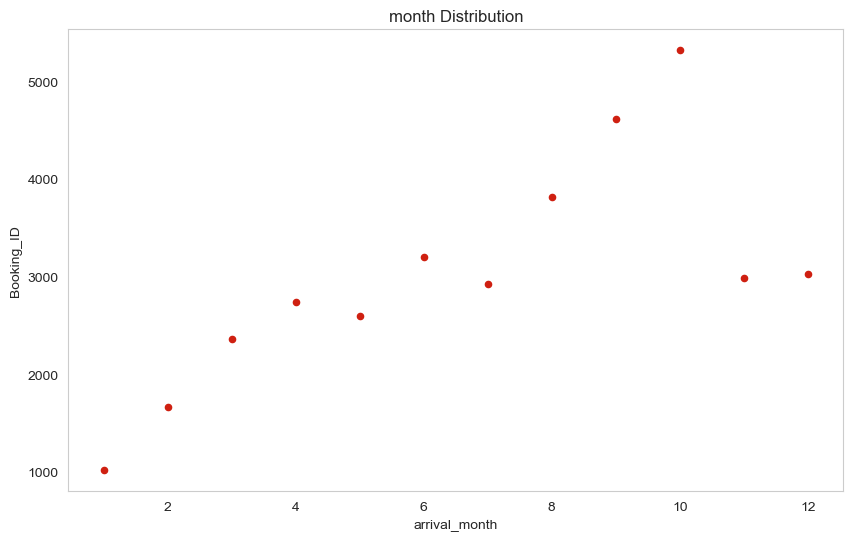

In [114]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
(tweak_hotel(hotel)
 .astype({'arrival_month': 'int8'})
 .groupby(by=['arrival_month'])
 .agg({'Booking_ID': 'count'})
 .reset_index()
 .plot
 .scatter(x='arrival_month', y='Booking_ID', ax=ax, title='month Distribution')
 )

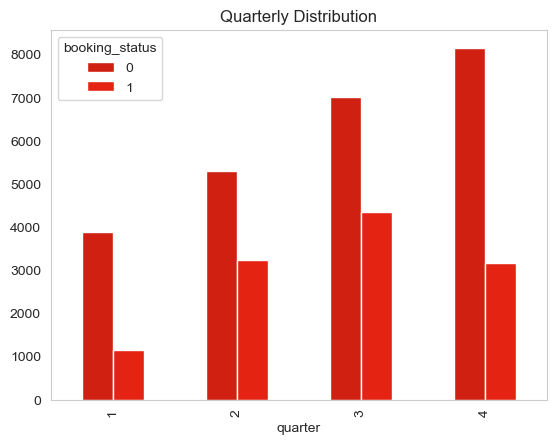

In [132]:
(tweak_hotel(hotel)
 .groupby(by=['quarter', 'booking_status'])
 .agg({'Booking_ID': 'count'})
#  .reset_index()
 .unstack(level=1)
 .plot
 .bar(y='Booking_ID', title='Quarterly Distribution')
 );